In [1]:
import pandas as pd
import numpy as np
from utils import *
from pymatgen.core import Composition
from Featurizor import Featurizor
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

config = {
    "mathtext.fontset": 'stix',
    "font.family": 'serif',
    "font.serif": ['Times New Roman'],
    "font.size": 24,
    'axes.unicode_minus': False
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False
large = 22
med = 16
small = 12
params = {
    'axes.titlesize': large,
    'legend.fontsize': med,
    'figure.figsize': (8, 6),
    'axes.labelsize': med,
    'axes.titlesize': med,
    'xtick.labelsize': med,
    'ytick.labelsize': med,
    'figure.titlesize': large
}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 300
seed = 42

In [2]:
from mp_api.client import MPRester
m = MPRester('nqUYyfjrG2R2IPVhuAy4GFqyGYaoWjbH')
spacegroup_numbers = [227]
result = []
C = ['O','S','Se','Te','Cl','F']
for spacegroup in spacegroup_numbers:
    for c in C:
        docs = m.summary.search(formula='*1*2{}4'.format(c), spacegroup_number= spacegroup)
        if len(docs) > 0:
            tmp_dict = {}
            for doc in docs:
                doc_dict = dict(doc)
                doc_dict['spacegroup_number'] = doc.symmetry.number
                result.append(doc_dict)
result  

Retrieving SummaryDoc documents:   0%|          | 0/170 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/106 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/42 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

[{'builder_meta': EmmetMeta(emmet_version='0.38.6', pymatgen_version='2022.10.22', pull_request=825, database_version='2022.10.28', build_date=datetime.datetime(2022, 10, 28, 0, 53, 46, 62000)),
  'nsites': 14,
  'elements': [Element Mn, Element Na, Element O],
  'nelements': 3,
  'composition': Composition('Na2 Mn4 O8'),
  'composition_reduced': Composition('Na1 Mn2 O4'),
  'formula_pretty': 'NaMn2O4',
  'formula_anonymous': 'AB2C4',
  'chemsys': 'Mn-Na-O',
  'volume': 151.3587971111742,
  'density': 4.319530429147743,
  'density_atomic': 10.811342650798156,
  'symmetry': SymmetryData(crystal_system=<CrystalSystem.cubic: 'Cubic'>, symbol='Fd-3m', number=227, point_group='m-3m', symprec=0.1, version='1.16.2'),
  'property_name': 'summary',
  'material_id': MPID(mp-760340),
  'deprecated': False,
  'deprecation_reasons': None,
  'last_updated': datetime.datetime(2022, 10, 28, 0, 53, 46, 63000),
  'origins': [],
  'warnings': [],
  'structure': Structure Summary
  Lattice
      abc : 5.9

In [3]:
spinels = pd.DataFrame(result)
spinels = spinels[['formula_pretty','is_gap_direct']]
spinels.columns=['formula',r'$y$']
spinels

formula    $y$
0      NaMn2O4  False
1    Cd(RhO2)2  False
2      CaIn2O4   True
3    Si(NiO2)2   True
4      Mg2FeO4  False
..         ...    ...
320   Dy2CdTe4  False
321   Cr2CuTe4  False
322   Li2ZnCl4  False
323    LiAg2F4  False
324    Li2MnF4   True

[325 rows x 2 columns]

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.5,random_state = seed)

for train_index,test_index in split.split(spinels,spinels[r'$y$']):
    train = spinels.iloc[train_index,:]
    test = spinels.iloc[test_index,:]

print(len(train),len(test))

162 163


In [5]:
spinels_train = train.reset_index(drop=True)

In [6]:
# columns = ['$R_b$','$V_a$','$Ns_a$','$Nd_b$','$Np_a$','$(En)diff_{cb}$','$o$','$Ce_a$']

In [7]:
data = Featurizor().featurize(spinels_train,is_structure=False)
y = data[r'$y$']
X = data.drop(columns=['formula',r'$y$'])
# X, y = RandomUnderSampler(random_state=seed).fit_resample(X, y)

MultipleFeaturizer:   0%|          | 0/158 [00:00<?, ?it/s]

In [8]:
from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicTransformer
from sklearn.metrics import matthews_corrcoef,accuracy_score,f1_score,roc_auc_score,classification_report,roc_curve, auc,precision_score
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.metrics import mutual_info_score
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _my_metric(y, y_pred, w):
    threshold = 0.5
    y_prob = sigmoid(y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    y_pred = np.where(sigmoid(y_pred) > threshold, 1, 0)
    mcc = matthews_corrcoef(y,y_pred)
    return 0.7*roc_auc + 0.3*mcc

my_metric = make_fitness(function=_my_metric, greater_is_better=True)
functions = ['add', 'sub', 'mul', 'div','log','sqrt','inv']

In [ ]:
def plot_binary_confusion_matrix(y_true, y_pred, classes=['Indirect', 'Direct'], normalize=False,
                                 title='Confusion Matrix', cmap=plt.cm.GnBu):

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [10]:
def cal_factors(X,y,X_test,y_test,name):
    preds = []
    for pc,s in zip([0.1,0.01,0.005,0.001],['Complexity1','Complexity2','Complexity3','Complexity4']):   
        est_gp = SymbolicTransformer(
                                population_size=3000,
                                generations=20,
                                metric=my_metric,
                                random_state=42,
                                verbose=1,
                                n_components=1,
                                parsimony_coefficient=pc,
                                feature_names=X.columns,
                                n_jobs=-1,
                                function_set=functions
                             )
        est_gp.fit(X,y)
        best_programs = est_gp._best_programs
        best_programs_dict = {}
        for p in best_programs:
            factor_name = 'alpha_' + str(best_programs.index(p) + 1)
            best_programs_dict[factor_name] = {'fitness':p.fitness_,'p':p}
            
        best_programs_dict = pd.DataFrame(best_programs_dict).T
        best_programs_dict = best_programs_dict.sort_values(by='fitness')
        for i,factor in  enumerate(best_programs_dict.iloc[:,-1]):
            dot_data = factor.export_graphviz()
            graph = graphviz.Source(dot_data)
            graph.render('images/factors/%s_factor_graph_pc%s' % (name,pc), format='png', cleanup=True)

        X_test_transform = est_gp.transform(X_test)[:,-1]
        y_pred = np.where(sigmoid(X_test_transform) > 0.5, 1, 0)
        preds.append(y_pred)
        y_prob = sigmoid(X_test_transform)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=s+' area = %0.3f' % roc_auc, lw=1.5, linestyle='-.', alpha=0.75)
        print(classification_report(y_test,y_pred))
        with open('images/factors/factor_%s.txt' % name, 'a') as f:
            f.write(str(best_programs_dict['p'].values[0].__str__()) + '\n')
        print(str(best_programs_dict['p'].values[0].__str__()))
    plt.plot([0, 1], [0, 1], 'r--', lw=1, alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.025])
    plt.xlim([-0.025, 1.0])
    plt.title( ' Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.show()
    return preds

MultipleFeaturizer:   0%|          | 0/157 [00:00<?, ?it/s]

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.65         0.347926       12         0.688728              N/A      1.39m
   1     2.19         0.440615        3         0.671321              N/A     19.23m
   2     1.65         0.503165        3         0.671321              N/A     20.16m
   3     1.03         0.526866        3         0.671321              N/A     18.65m
   4     1.03         0.527864        1         0.529998              N/A     17.59m
   5     1.03         0.528351        3         0.573821              N/A     16.17m
   6     1.03         0.527415        1         0.529998              N/A     15.05m
   7     1.04         0.527457        2         0.537221              N/A     13.76m
   8     1.03         0.528049        1         0.529998              N/A  

  12    22.71         0.599397       24         0.785747              N/A     10.10m
  13    23.08         0.606047       24         0.785747              N/A      8.79m
  14    23.54         0.617724       24         0.785747              N/A      7.29m
  15    23.91         0.615187       27         0.786495              N/A      5.82m
  16    23.71         0.620536       32         0.787206              N/A      4.39m
  17    23.54         0.621605       30         0.789833              N/A      2.87m
  18    23.50         0.622484       30         0.791457              N/A      1.46m
  19    23.36         0.623102       30         0.791457              N/A      0.00s
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       117
           1       0.67      0.60      0.63        40

    accuracy                           0.82       157
   macro avg       0.77      0.75      0.76       157
weighted avg       0.82      0.82      0.82     

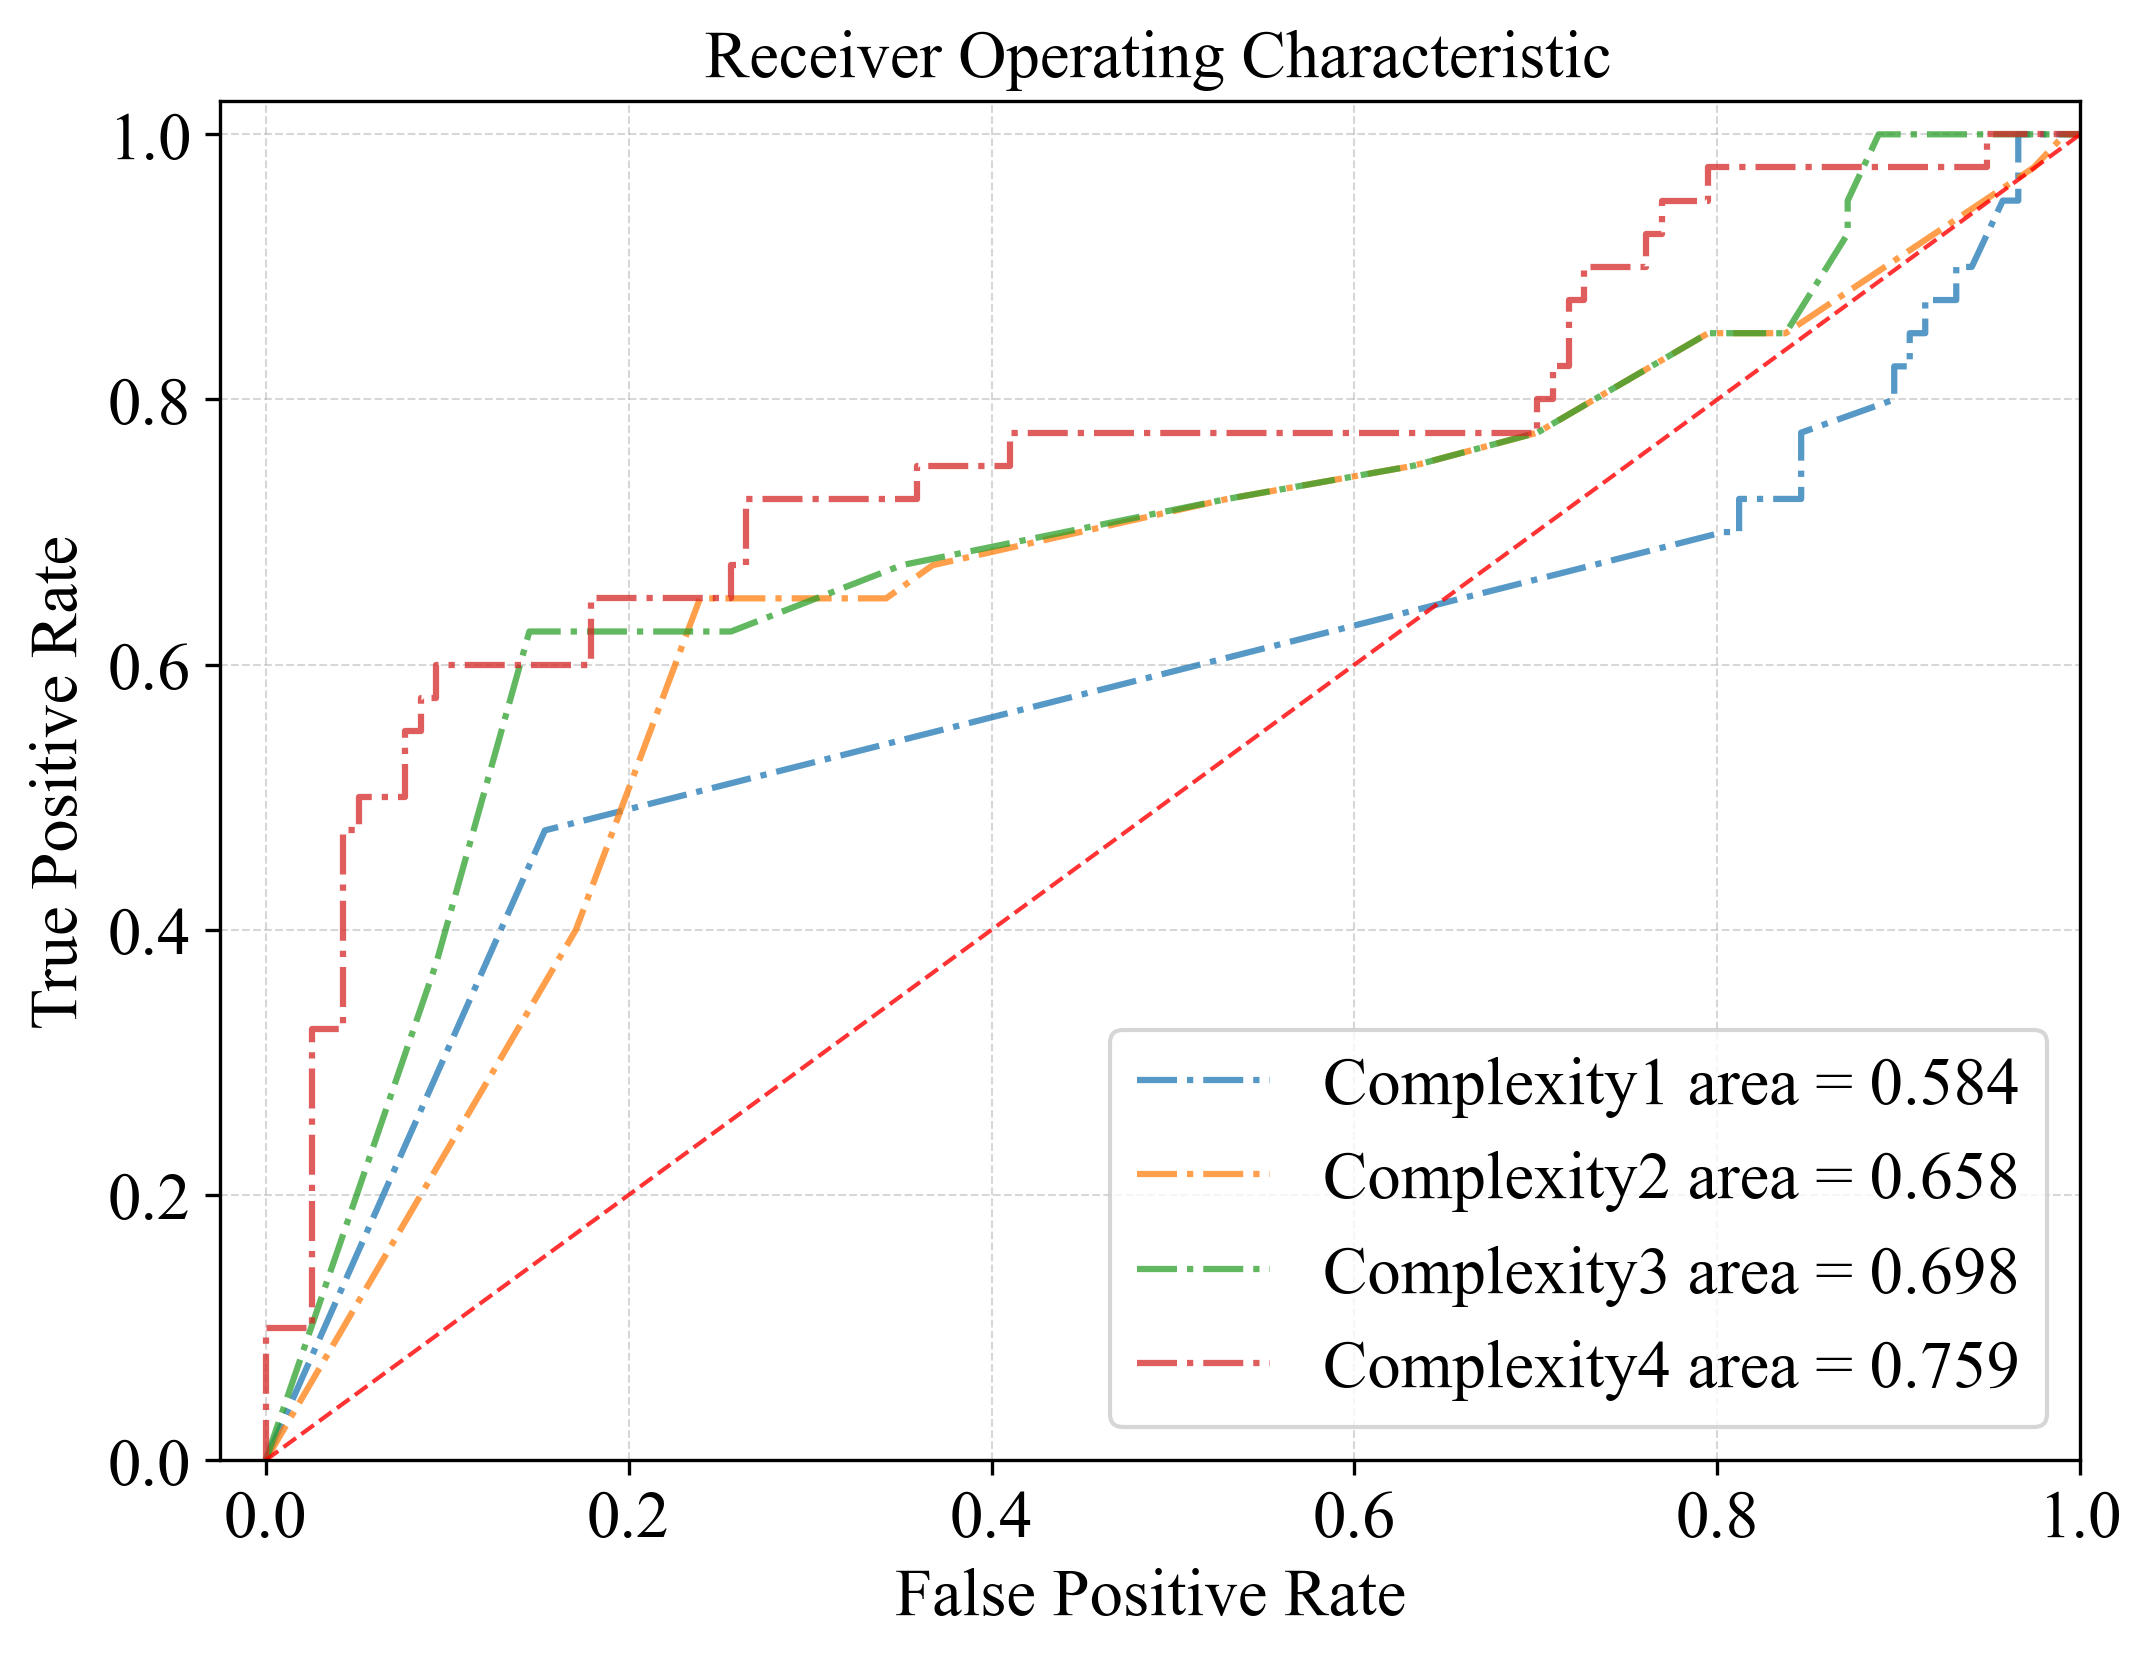

In [11]:
data_test = Featurizor(is_base=True).featurize(test,is_new_data=True,is_structure=False)
y_test = data_test[r'$y$']
X_test = data_test[X.columns]
preds = cal_factors(X,y,X_test,y_test,"test1")

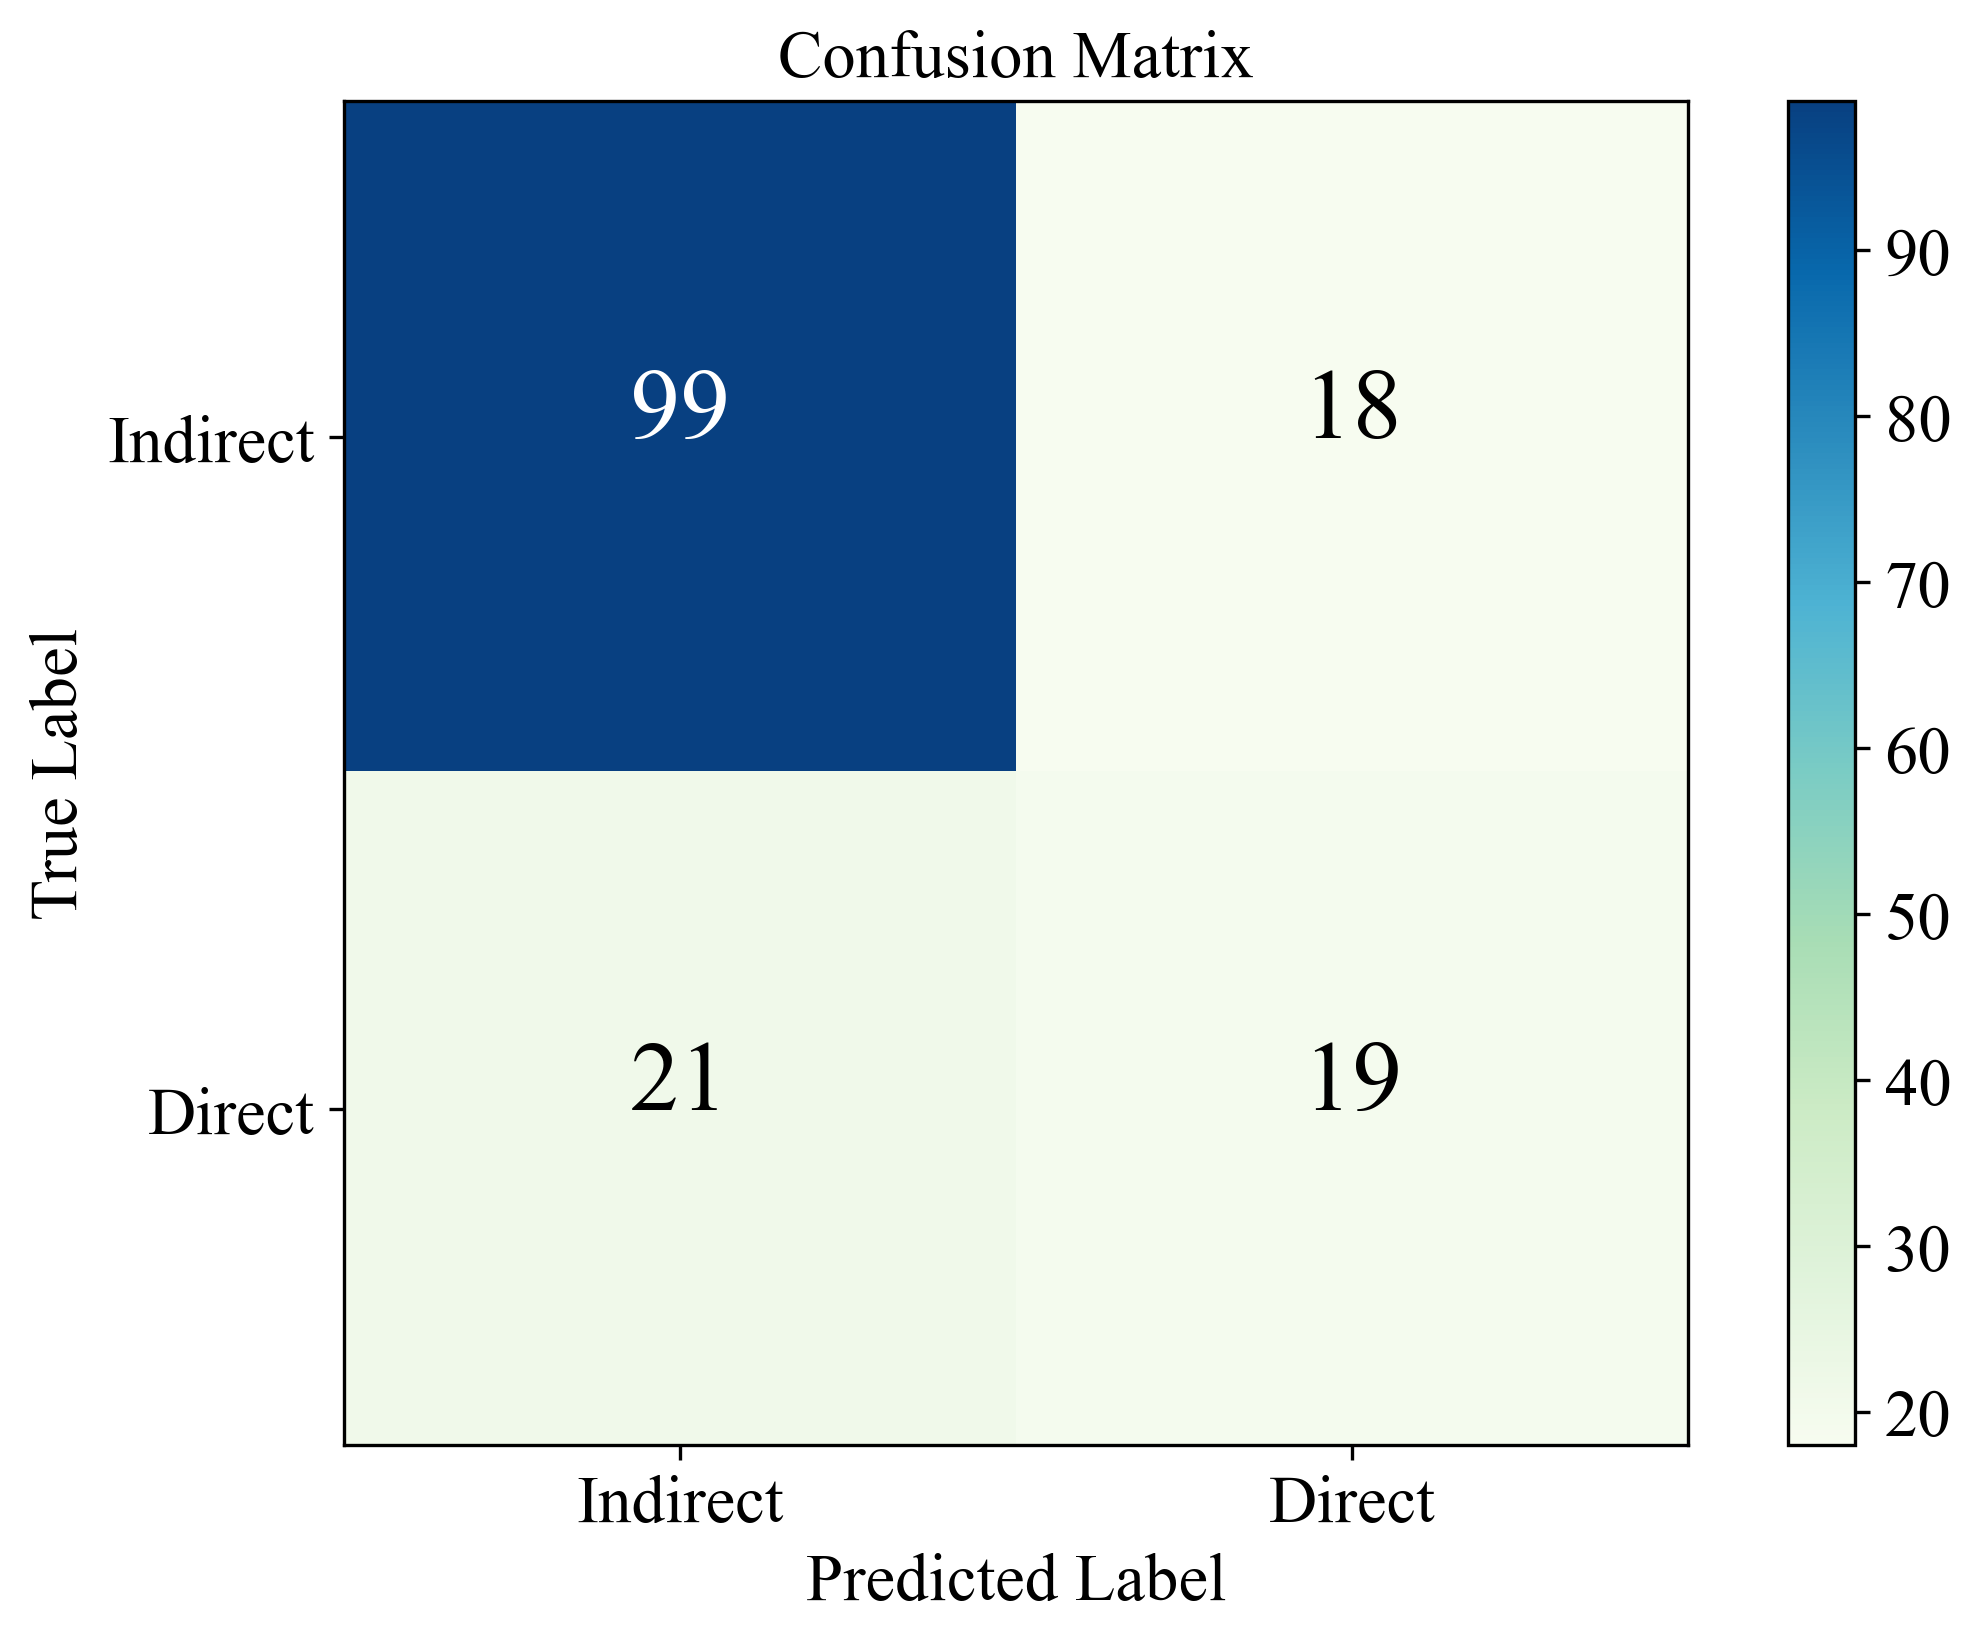

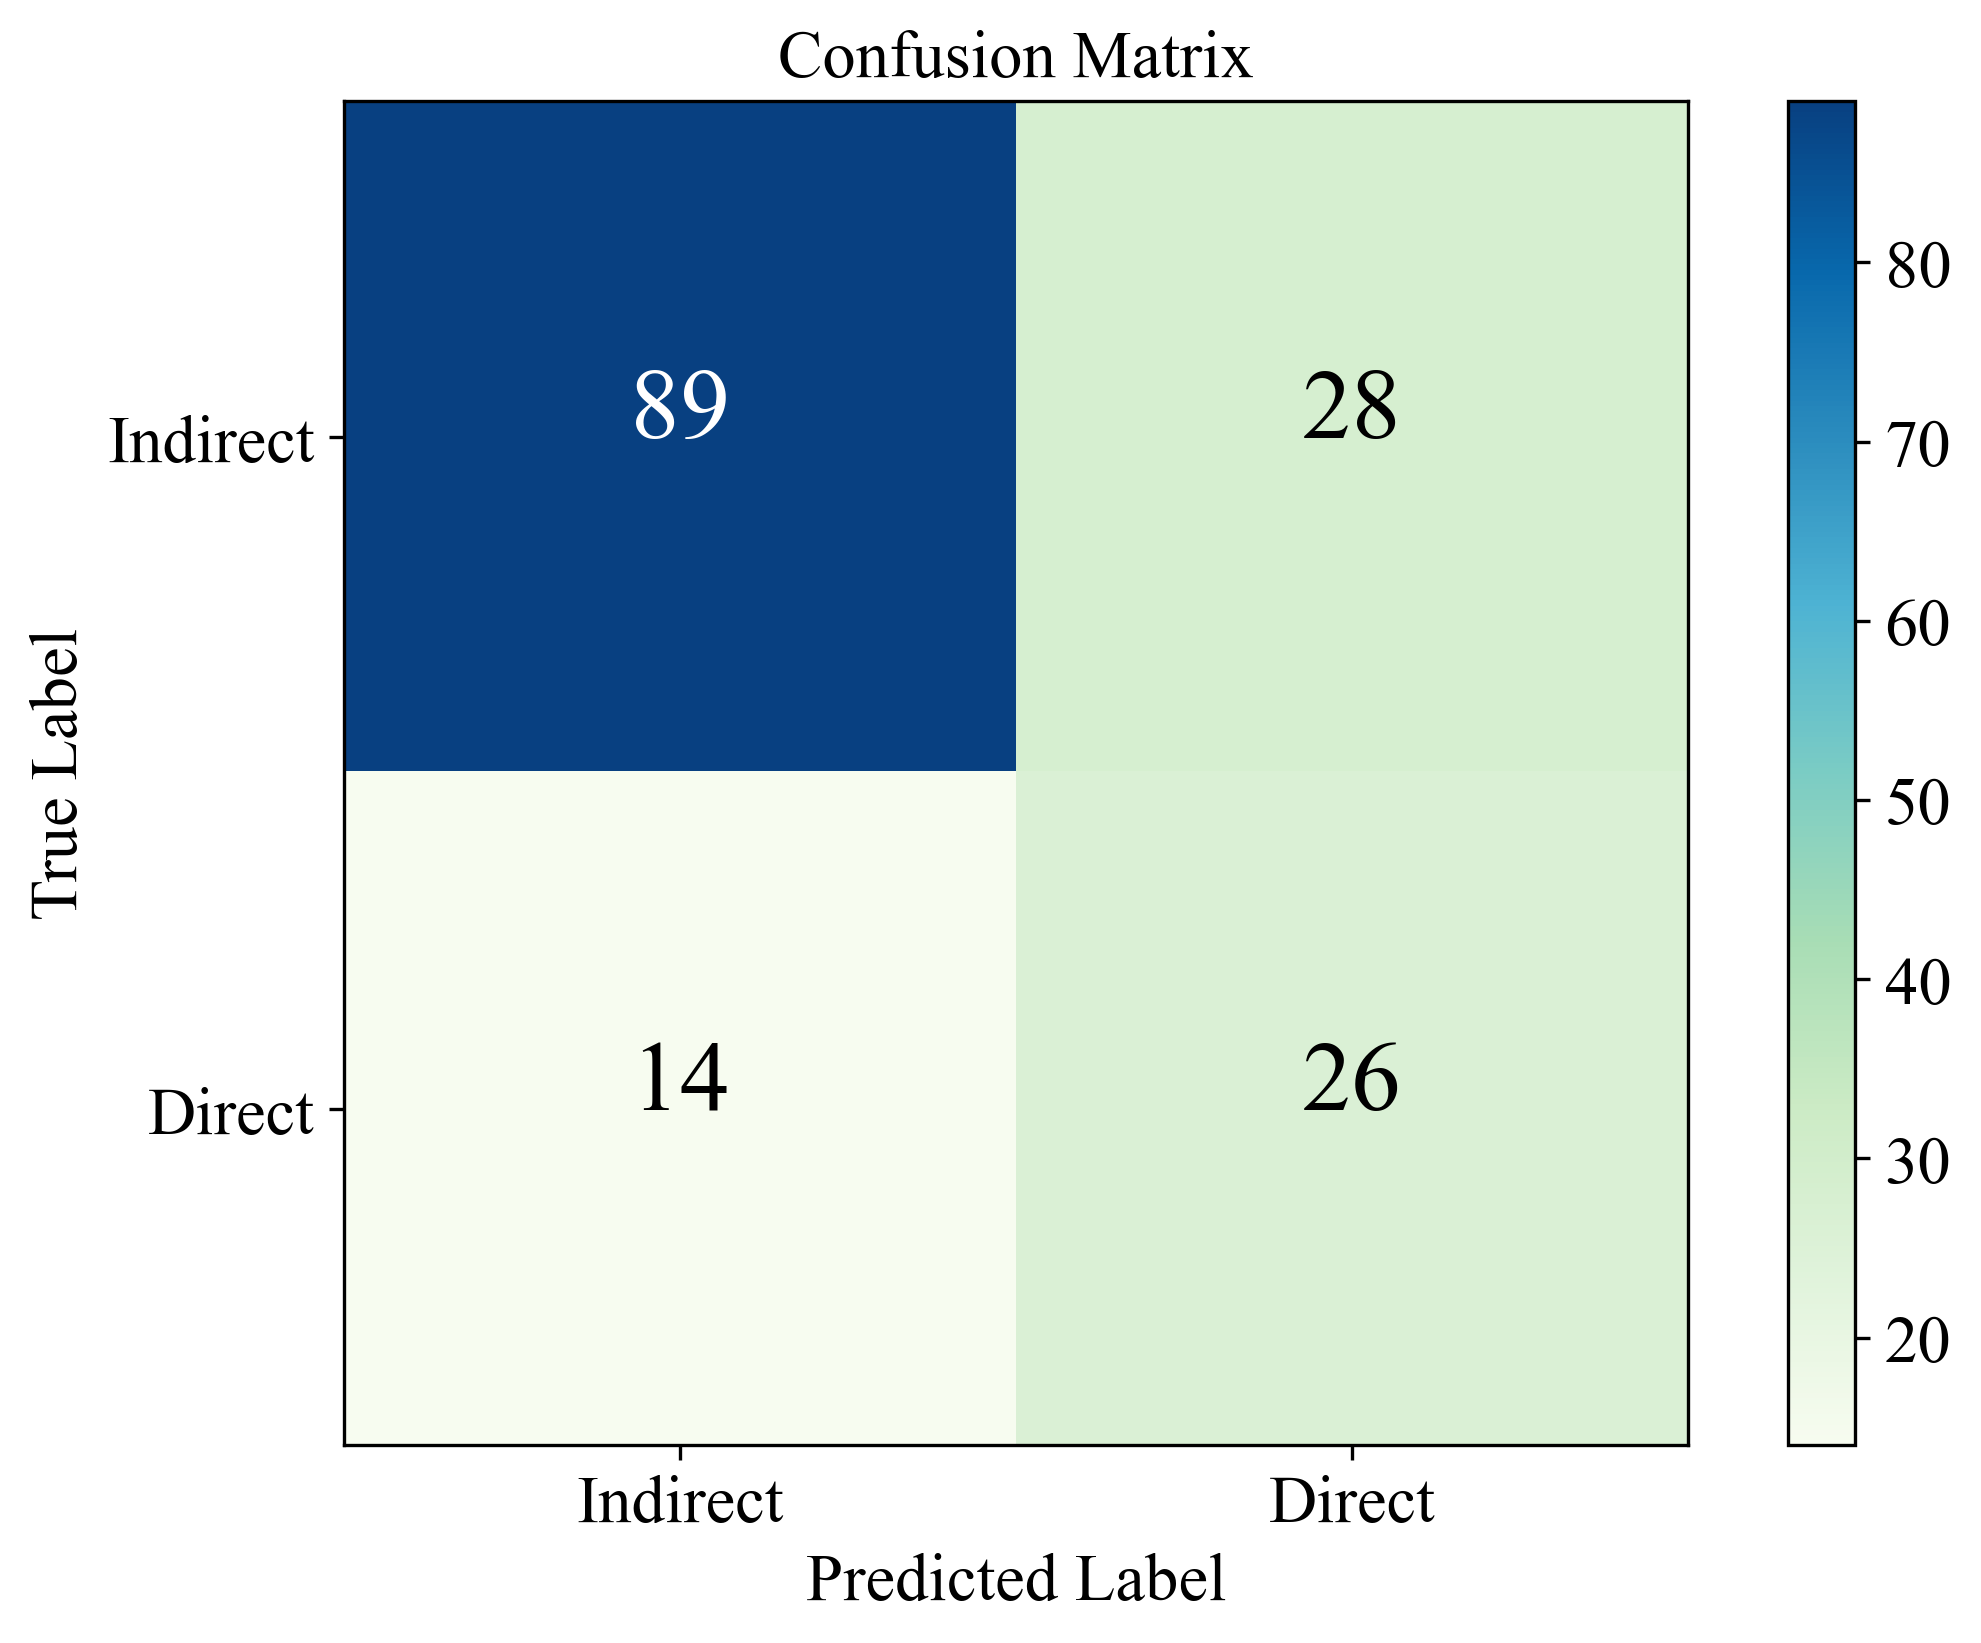

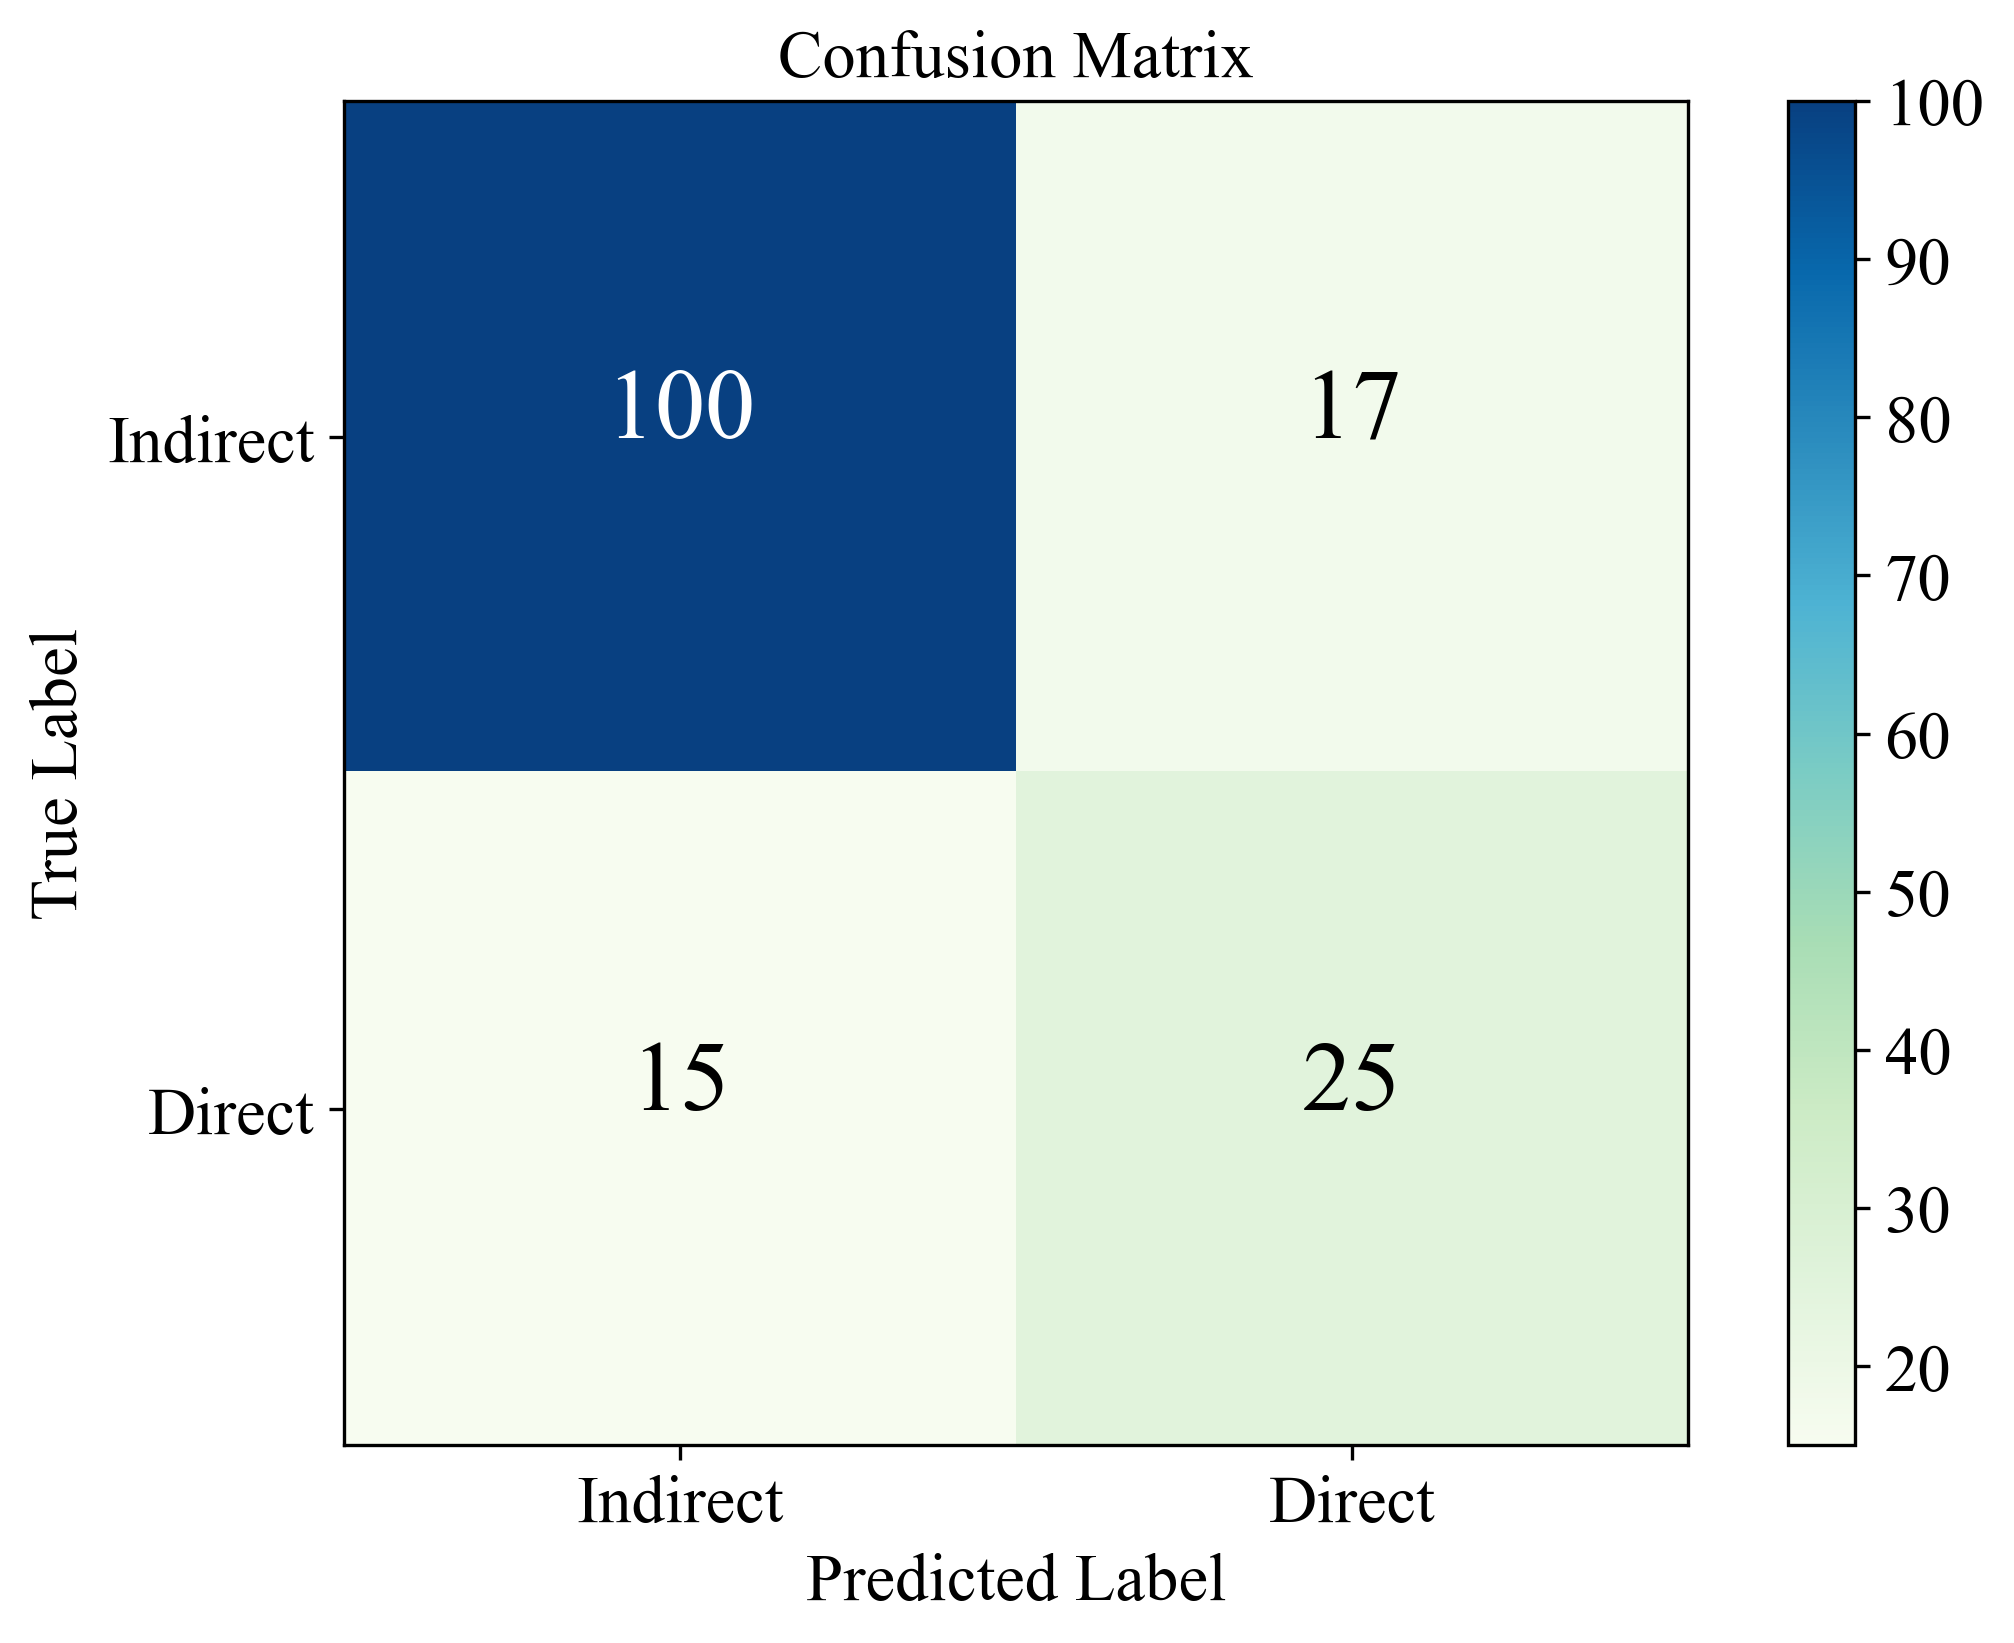

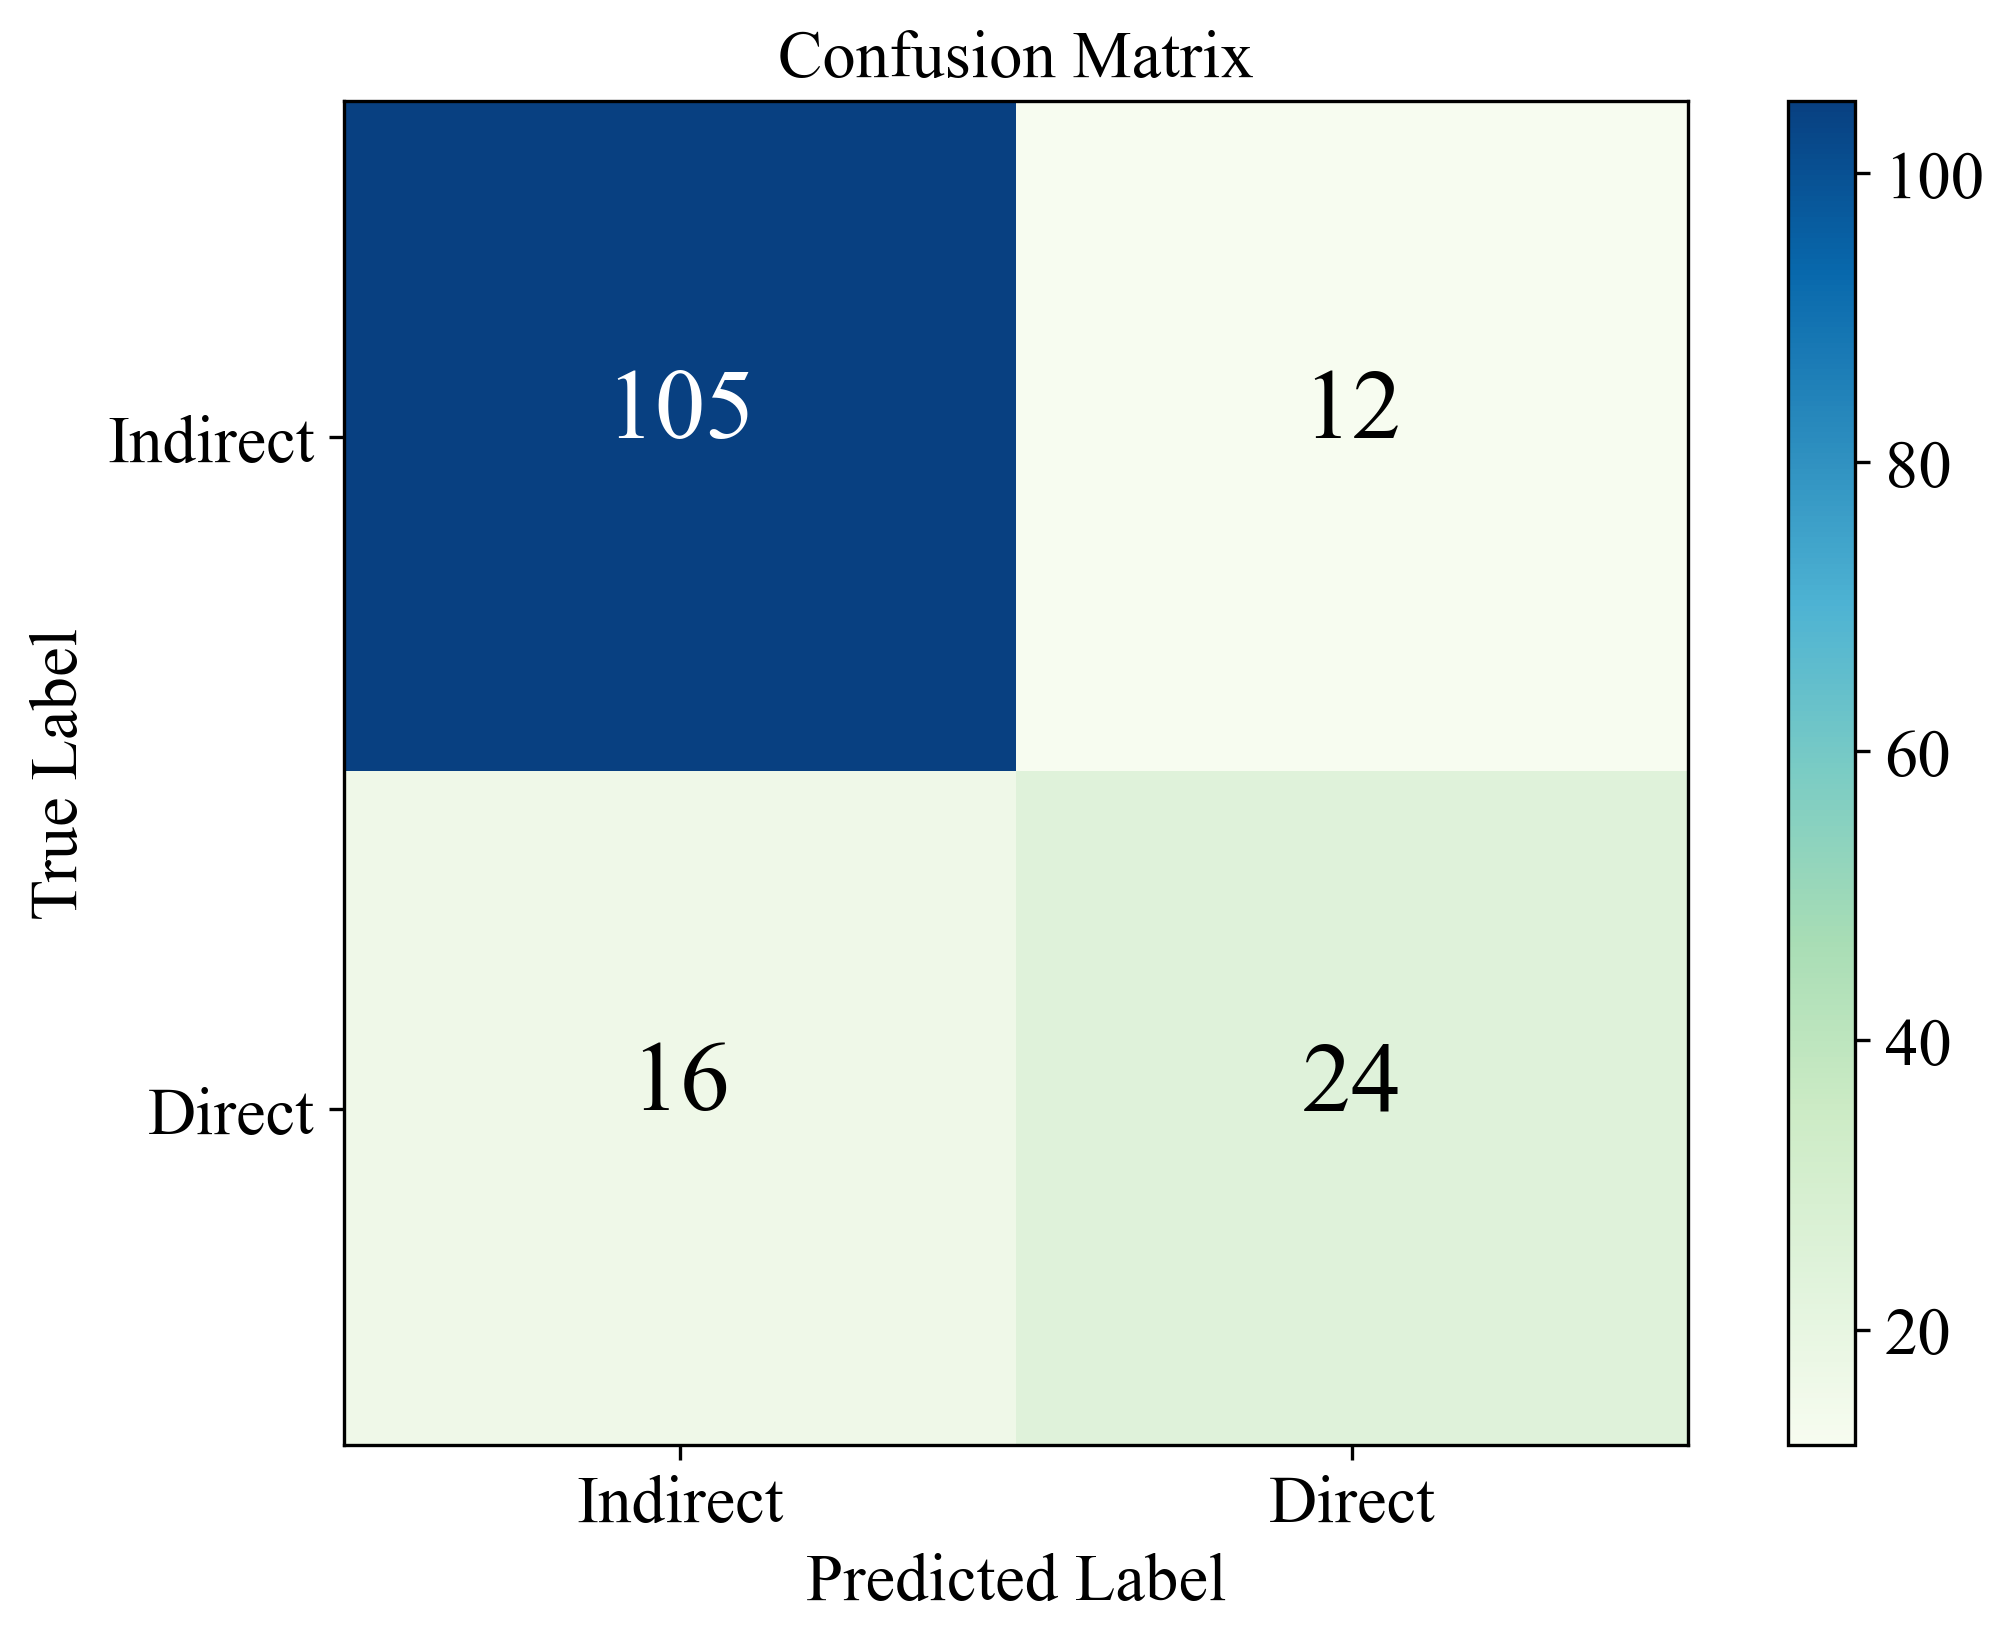

In [12]:
for y_pred in preds:
    plot_binary_confusion_matrix(y_test,y_pred)

In [13]:
def cal_factors(X,y,X_test,y_test,name):
    preds = []
    for s,population_size in enumerate([1000,3000,5000,8000,10000]):   
        est_gp = SymbolicTransformer(
                                population_size=population_size,
                                generations=20,
                                metric=my_metric,
                                random_state=42,
                                verbose=1,
                                n_components=1,
                                parsimony_coefficient=0.005,
                                feature_names=X.columns,
                                n_jobs=1,
                                function_set=functions
                             )
        est_gp.fit(X,y)
        best_programs = est_gp._best_programs
        best_programs_dict = {}
        for p in best_programs:
            factor_name = 'alpha_' + str(best_programs.index(p) + 1)
            best_programs_dict[factor_name] = {'fitness':p.fitness_,'p':p}
        best_programs_dict = pd.DataFrame(best_programs_dict).T
        best_programs_dict = best_programs_dict.sort_values(by='fitness')
        for i,factor in  enumerate(best_programs_dict.iloc[:,-1]):
            dot_data = factor.export_graphviz()
            graph = graphviz.Source(dot_data)
            graph.render('images/factors/%s_factor_graph_pc%s' % (name,population_size), format='png', cleanup=True)

        X_test_transform = est_gp.transform(X_test)[:,-1]
        y_pred = np.where(sigmoid(X_test_transform) > 0.5, 1, 0)
        preds.append(y_pred)
        y_prob = sigmoid(X_test_transform)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='alpha%s'%(s+1)+' area = %0.3f' % roc_auc, lw=1.5, linestyle='-.', alpha=0.75)
        print(classification_report(y_test,y_pred))
        with open('images/factors/factor_%s.txt' % name, 'a') as f:
            f.write(str(best_programs_dict['p'].values[0].__str__()) + '\n')
        print(str(best_programs_dict['p'].values[0].__str__()))
    plt.plot([0, 1], [0, 1], 'r--', lw=1, alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0.0, 1.025])
    plt.xlim([-0.025, 1.0])
    plt.title( 'Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.show()
    return preds

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.82         0.345009       12         0.688728              N/A     25.01s
   1     5.05         0.432157       10         0.710395              N/A     23.57s
   2     6.71         0.441813       10         0.710395              N/A     22.57s
   3     7.82         0.473639        9         0.741404              N/A     25.07s
   4     6.58          0.50056       13         0.750889              N/A     19.94s
   5     6.50         0.515163       13         0.750889              N/A     18.65s
   6     7.65         0.487872       12         0.755704              N/A     17.37s
   7     9.11         0.530034       15          0.75658              N/A     16.21s
   8     9.18          0.55335       17         0.750962              N/A  

  12     6.99         0.624567        7         0.736834              N/A      1.31m
  13     7.00         0.624713        7         0.736834              N/A      1.15m
  14     7.01         0.621699        7         0.736834              N/A     56.40s
  15     6.99         0.622107        7         0.736834              N/A     45.15s
  16     7.00         0.622985        7         0.736834              N/A     33.88s
  17     6.96         0.622887        7         0.736834              N/A     23.14s
  18     7.00         0.622595        7         0.736834              N/A     11.33s
  19     6.95         0.624071        7         0.736834              N/A      0.00s
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       117
           1       0.52      0.60      0.56        40

    accuracy                           0.76       157
   macro avg       0.69      0.71      0.70       157
weighted avg       0.77      0.76      0.76     

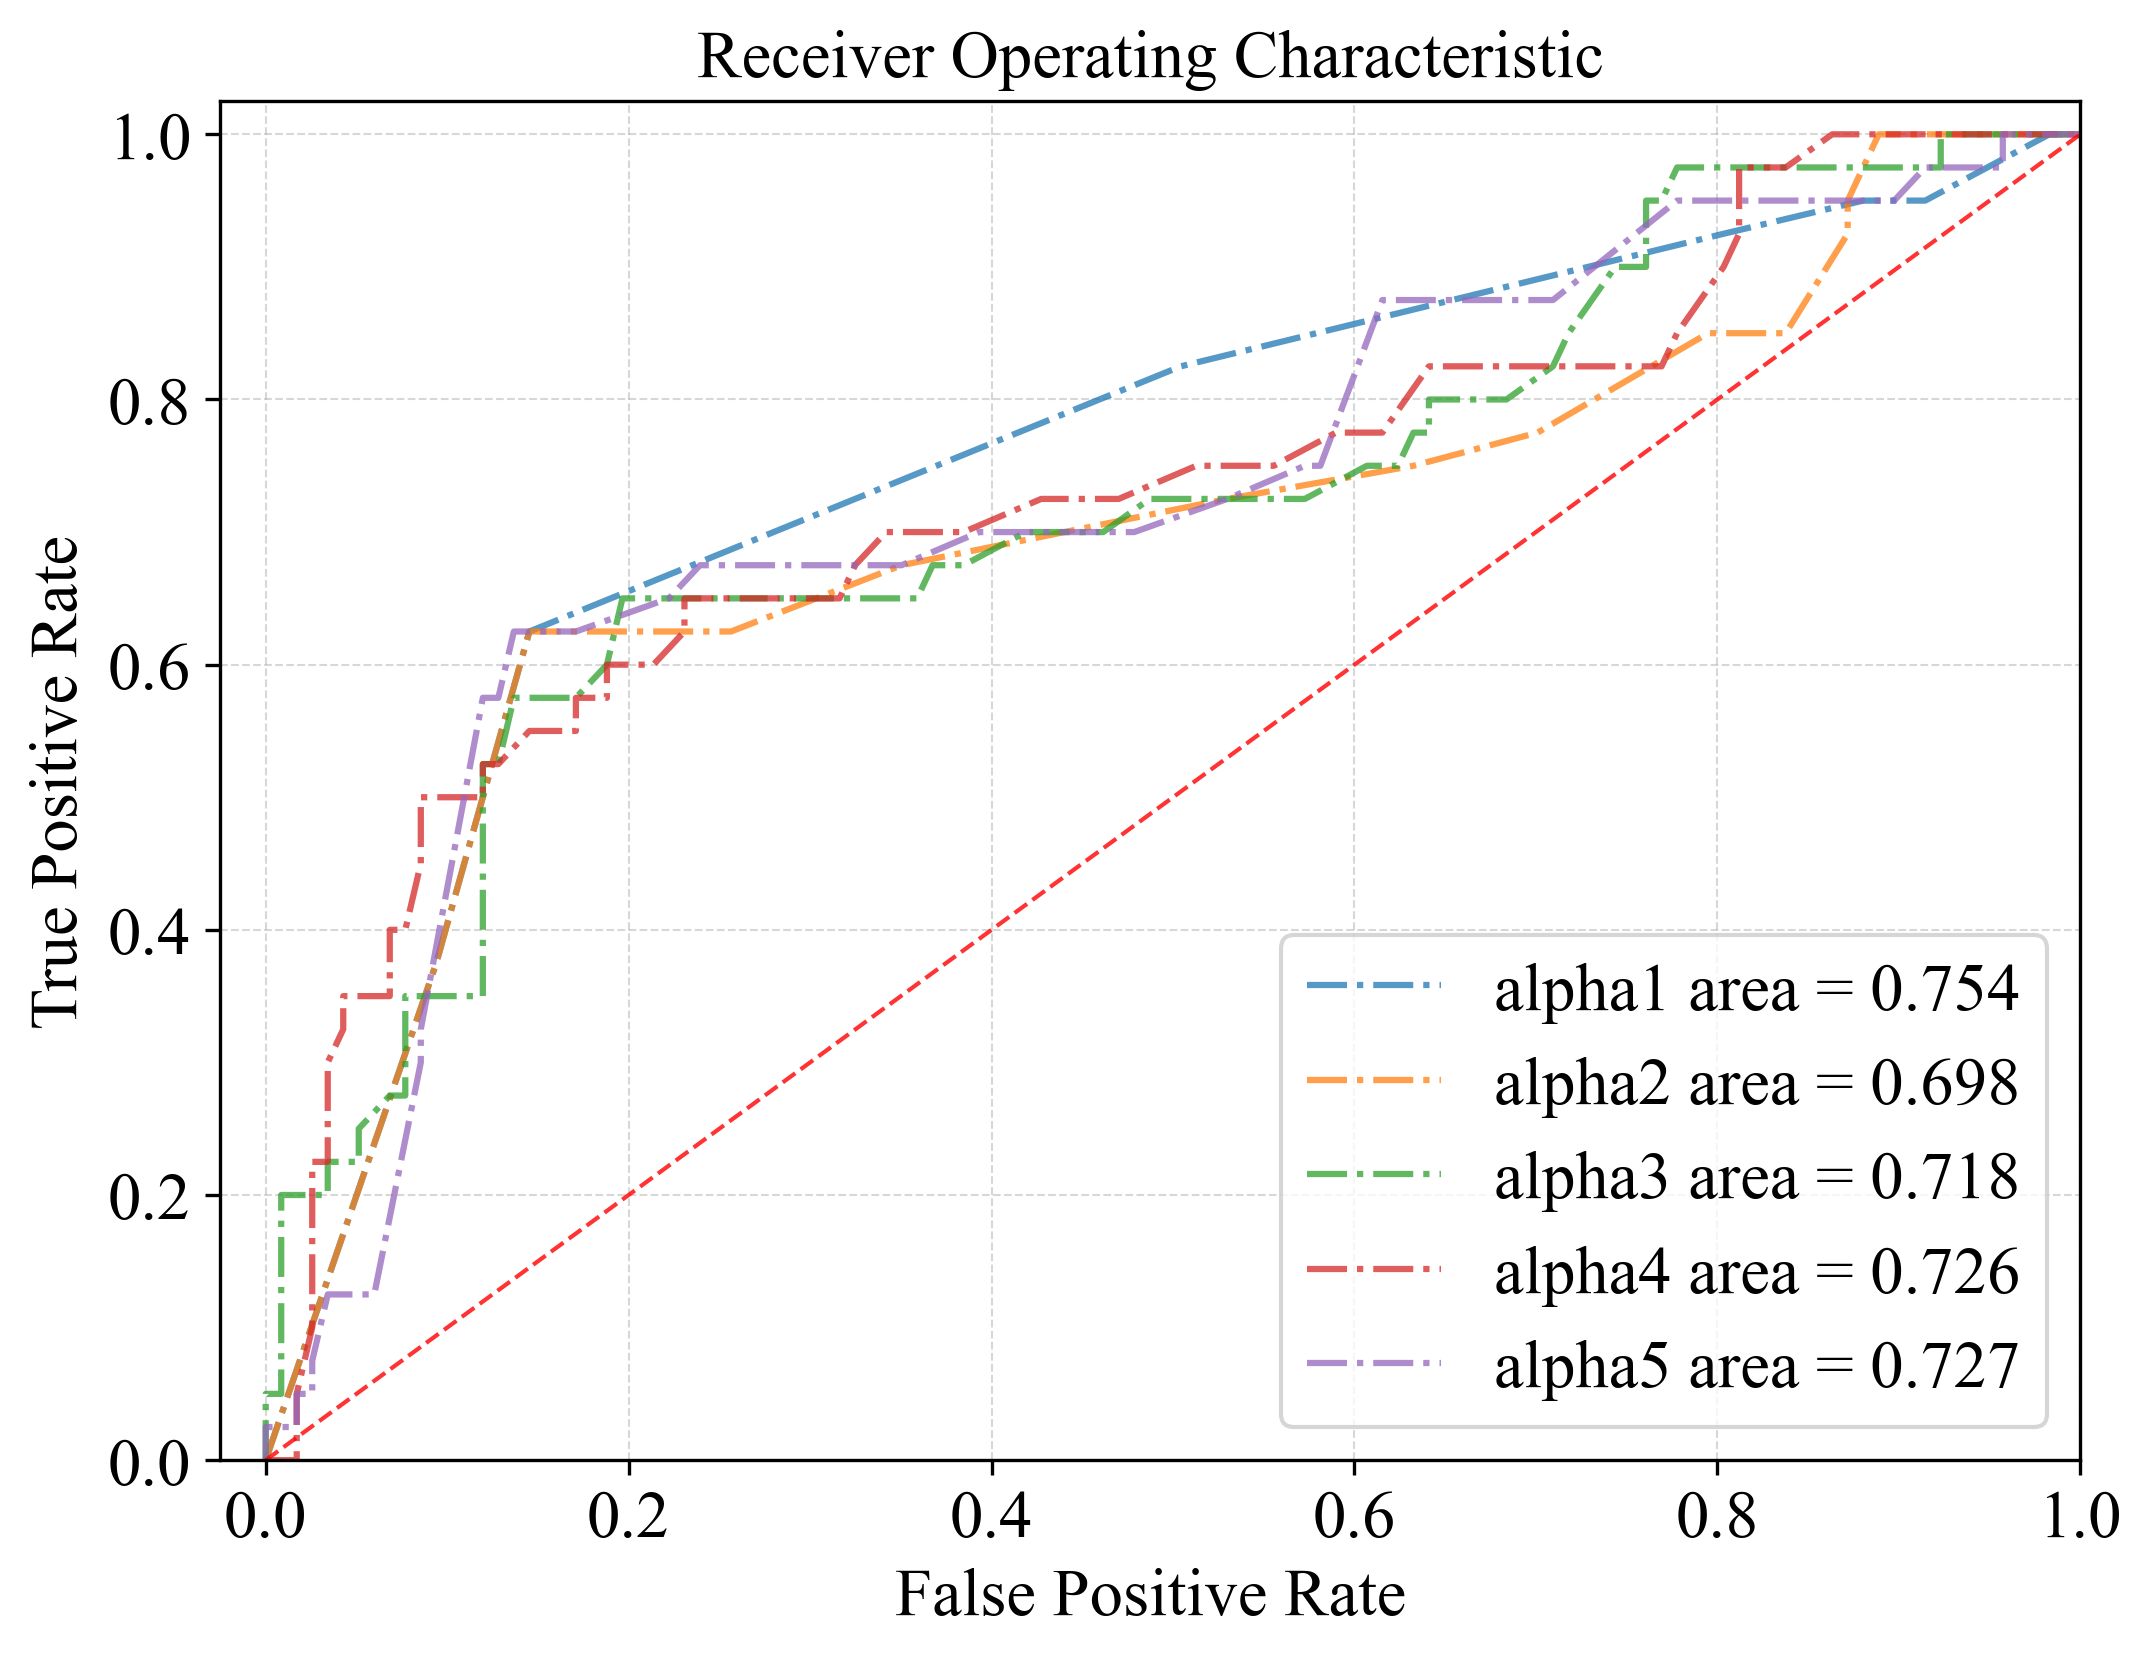

In [14]:
preds = cal_factors(X,y,X_test,y_test,"test2")

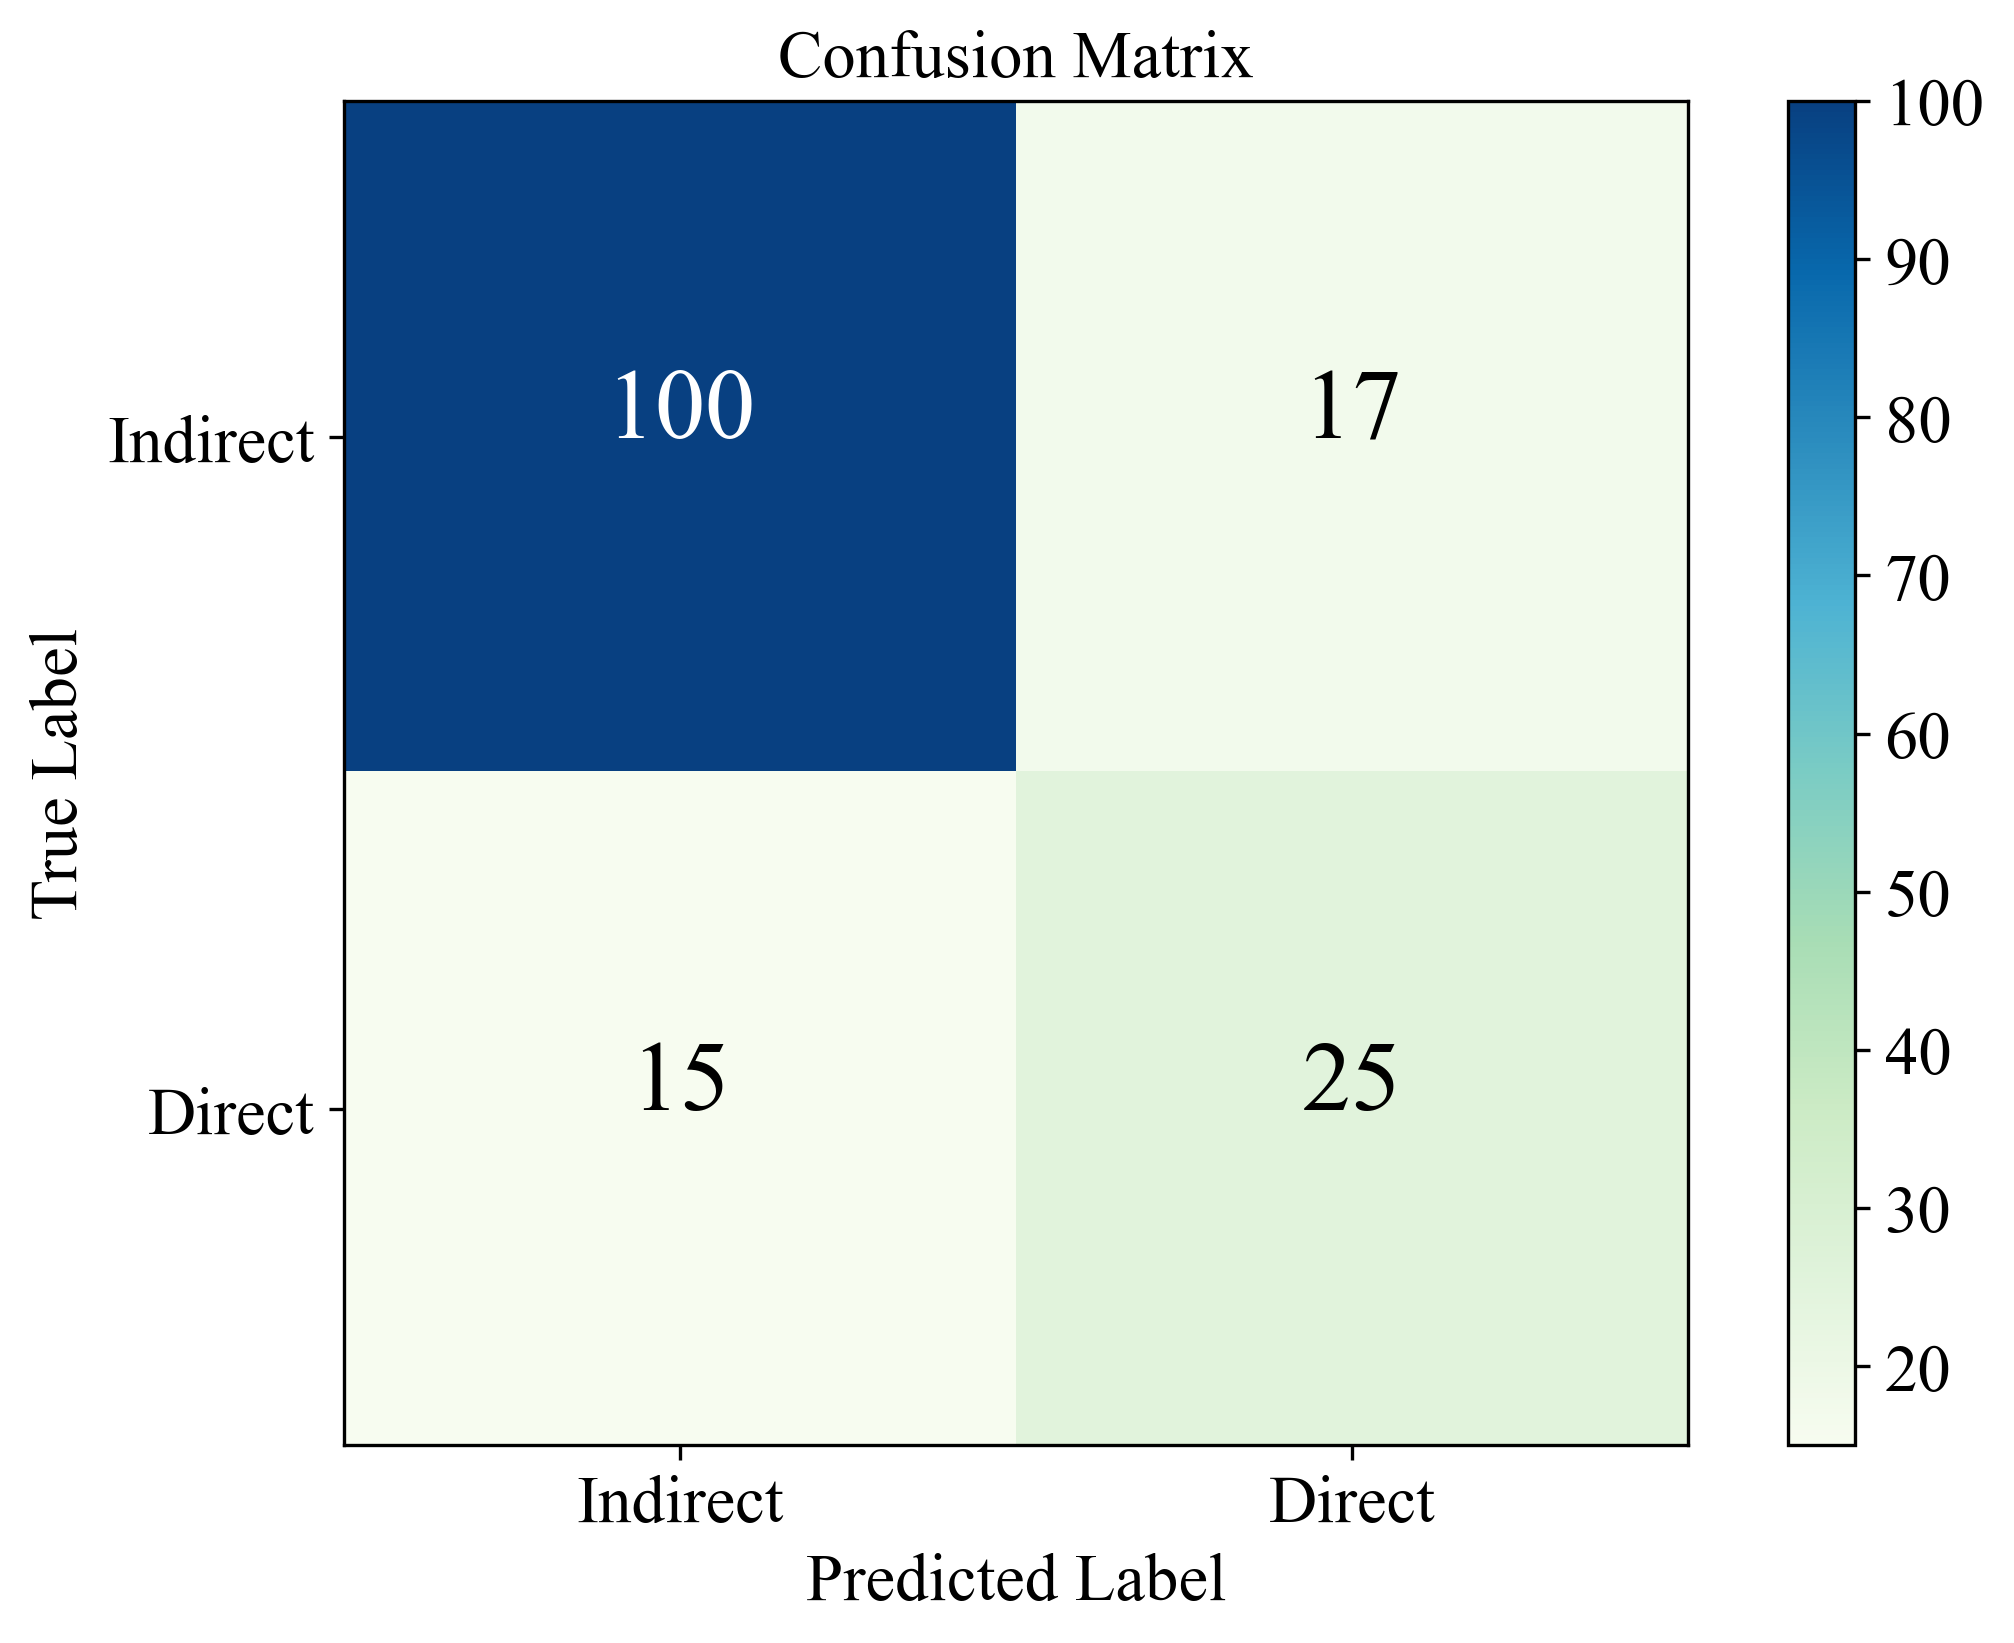

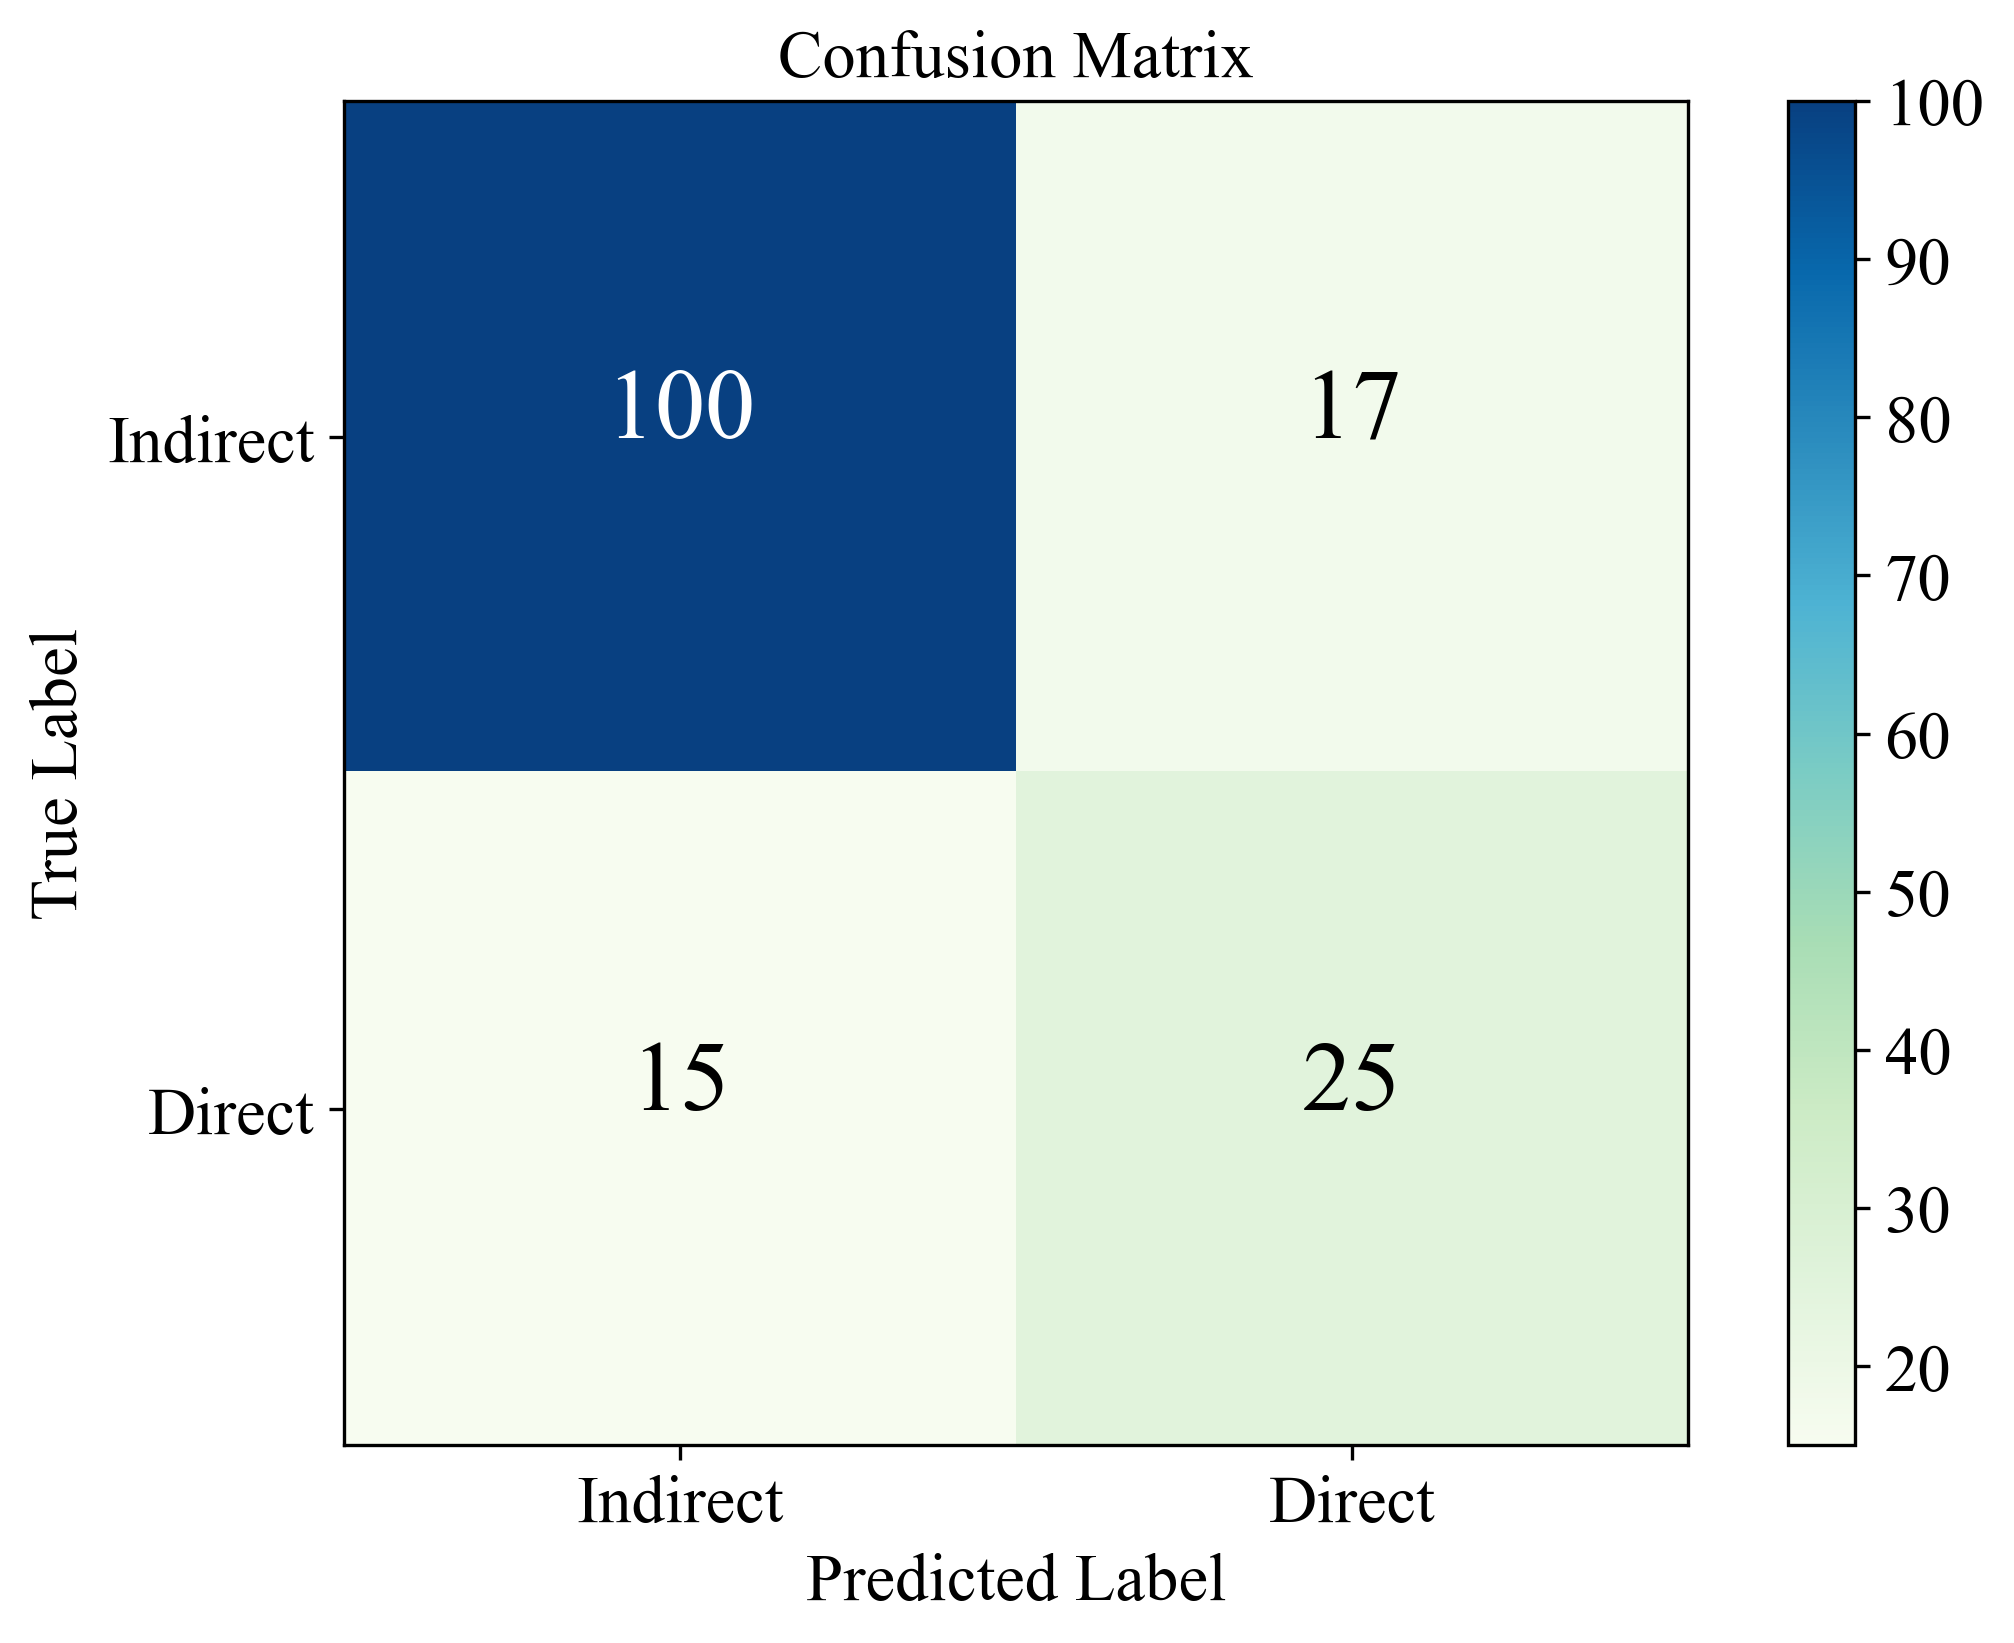

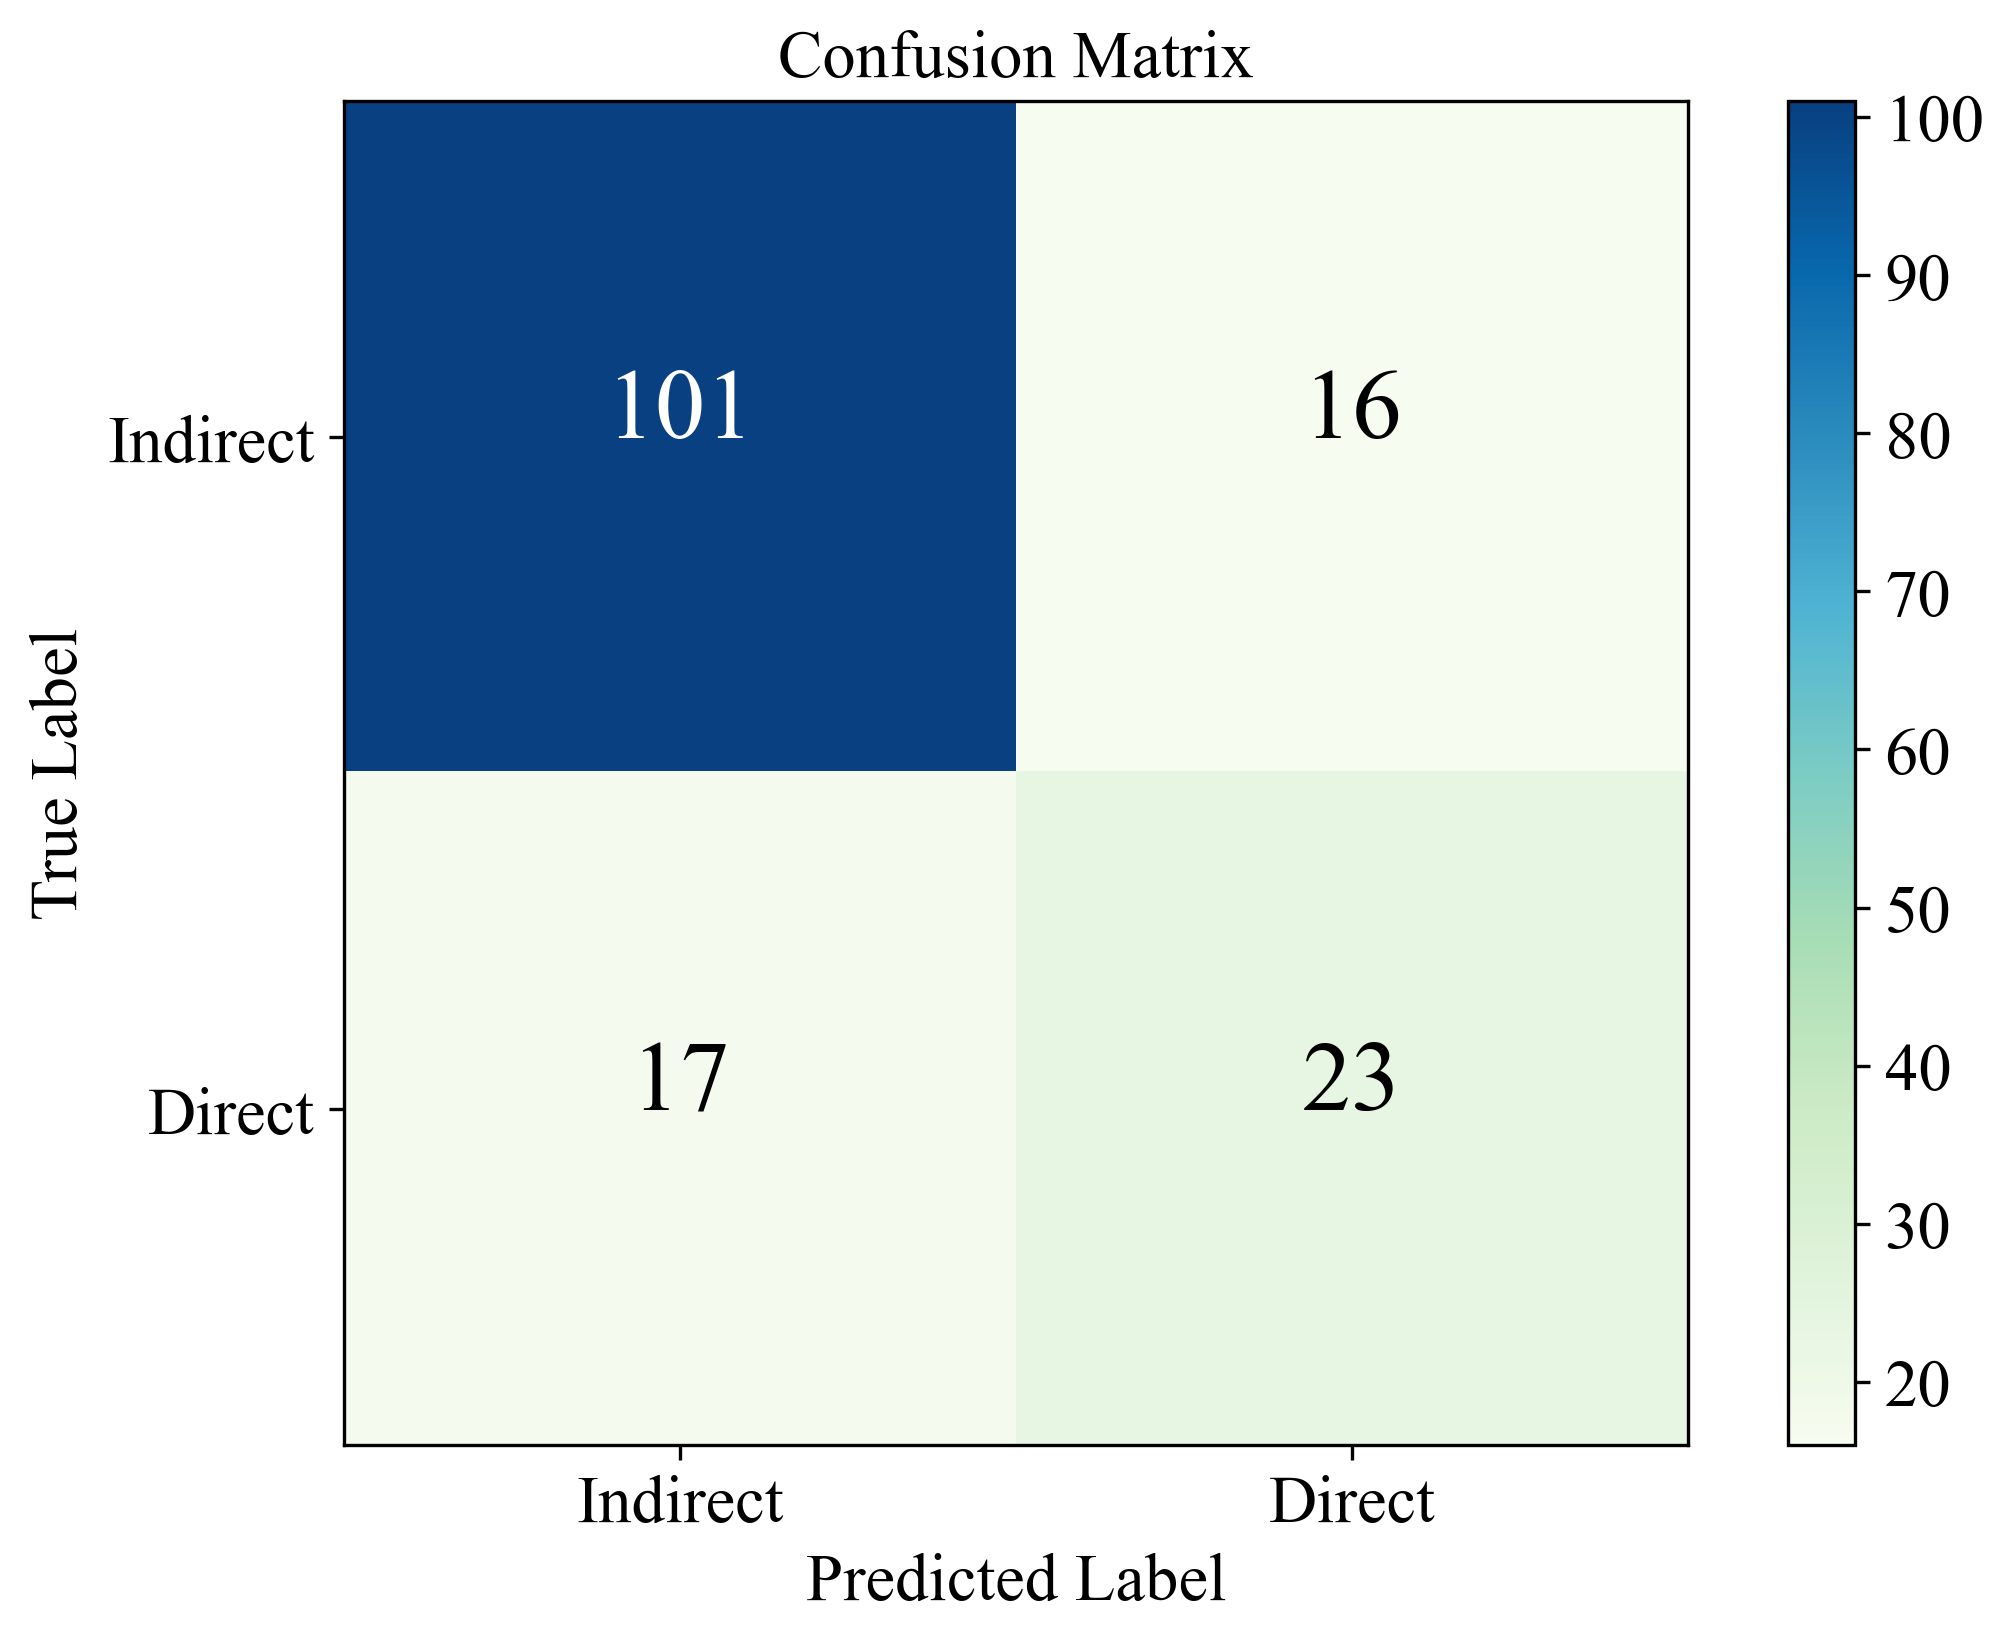

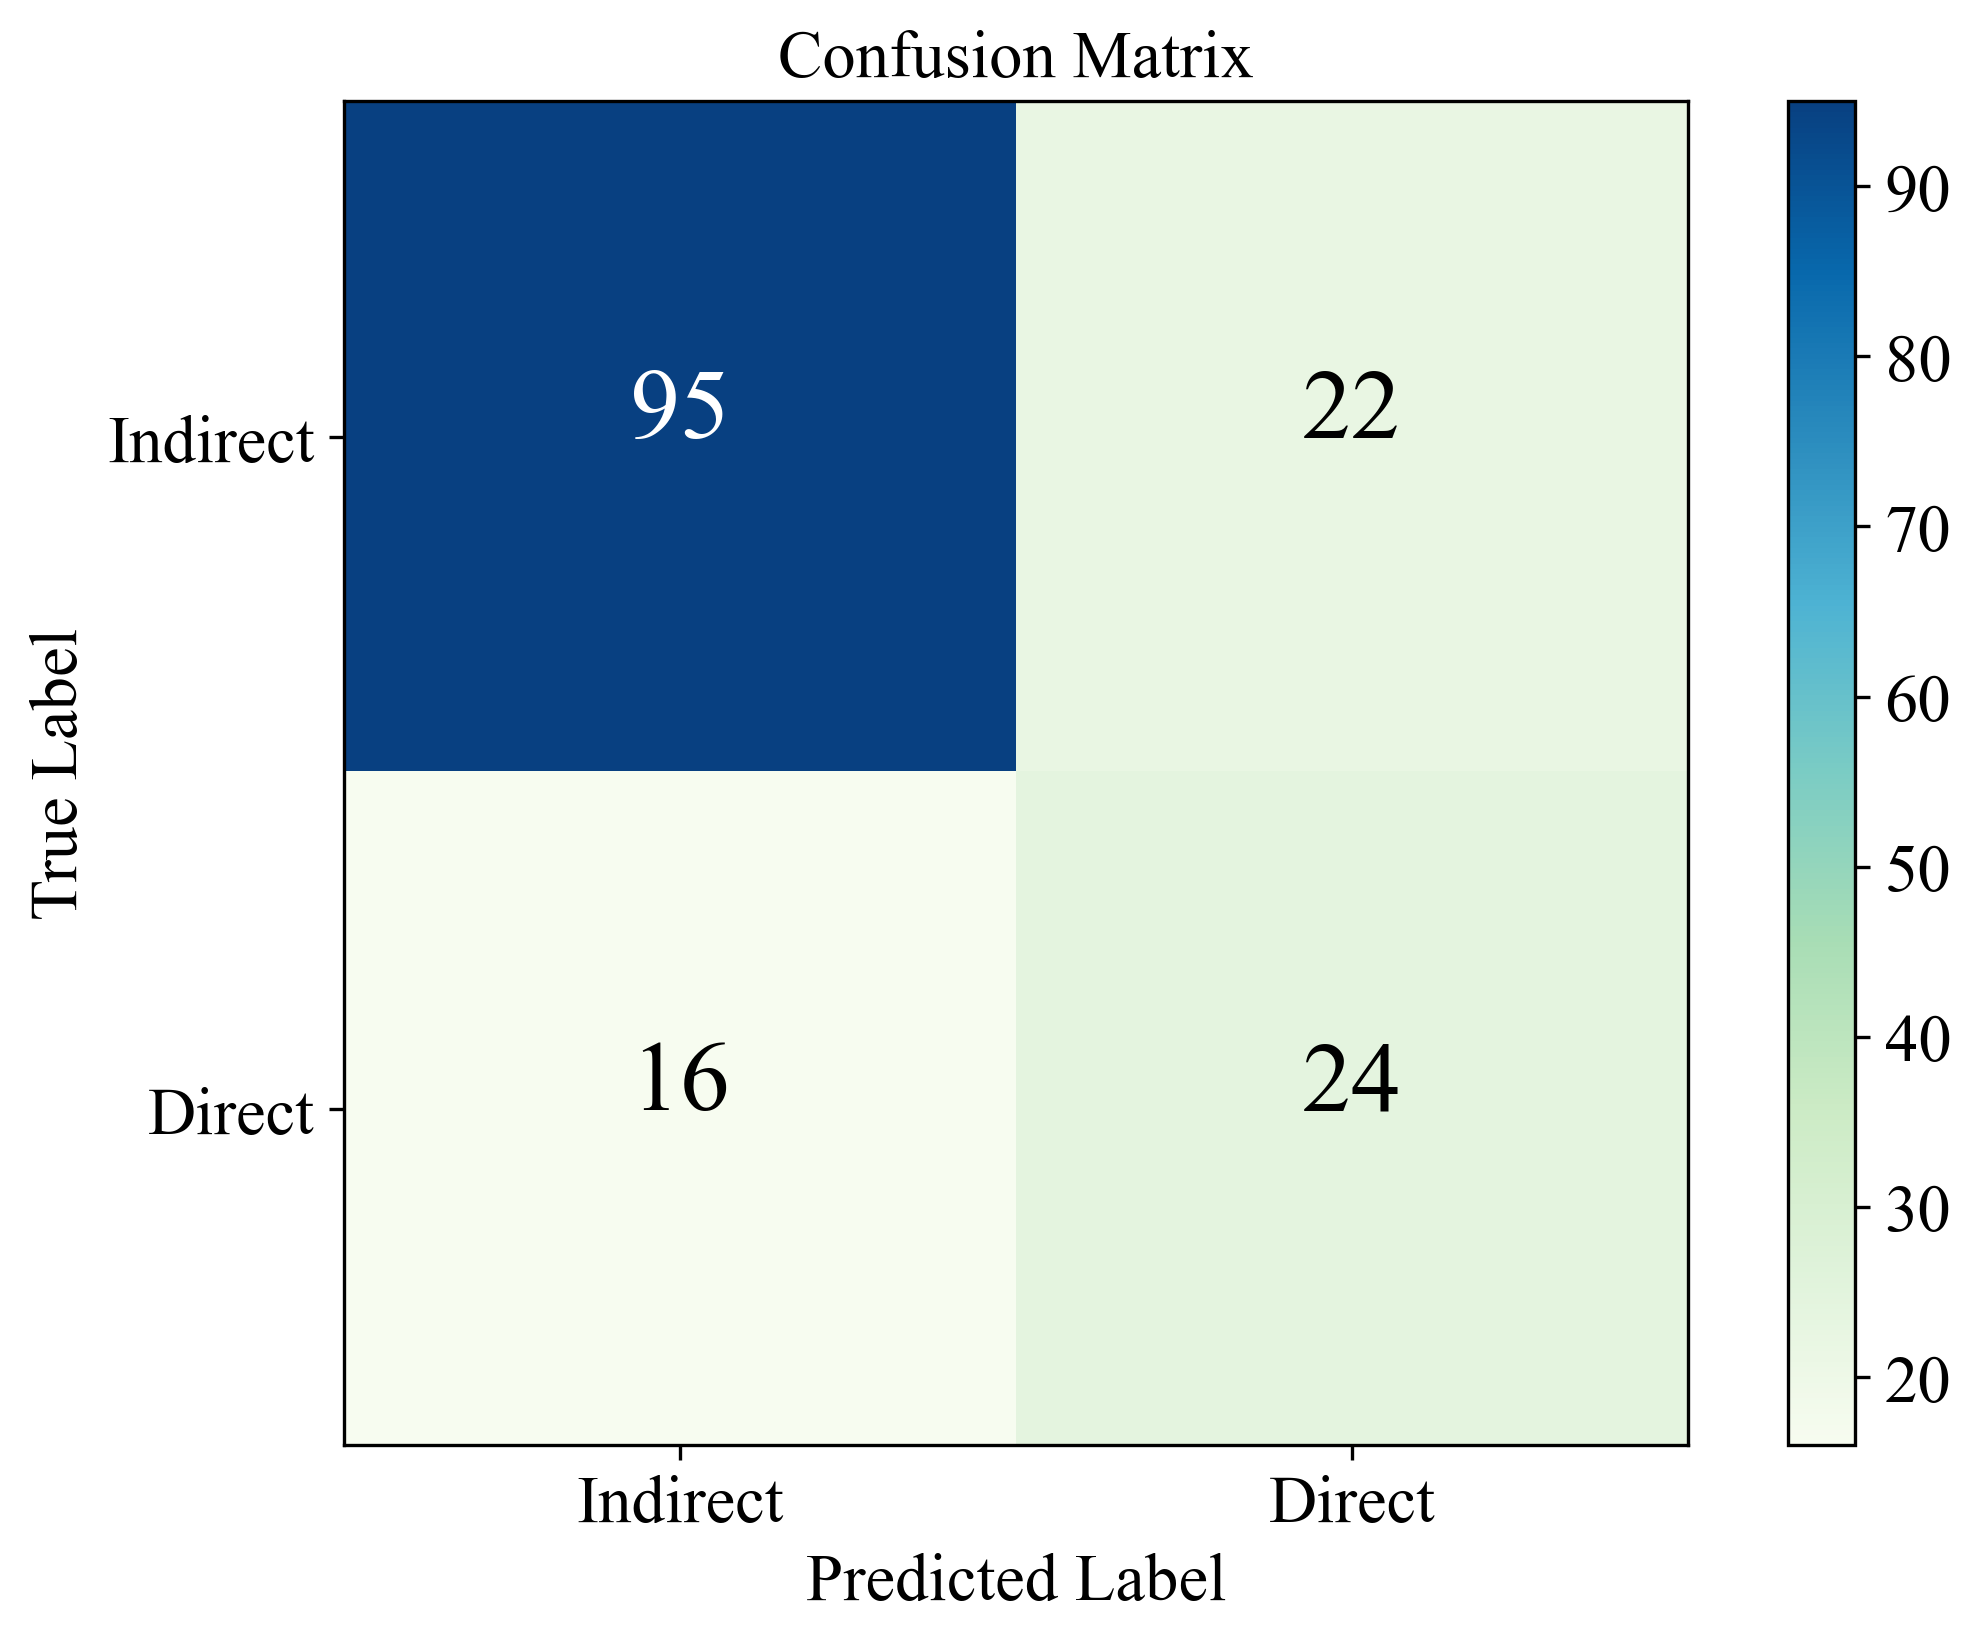

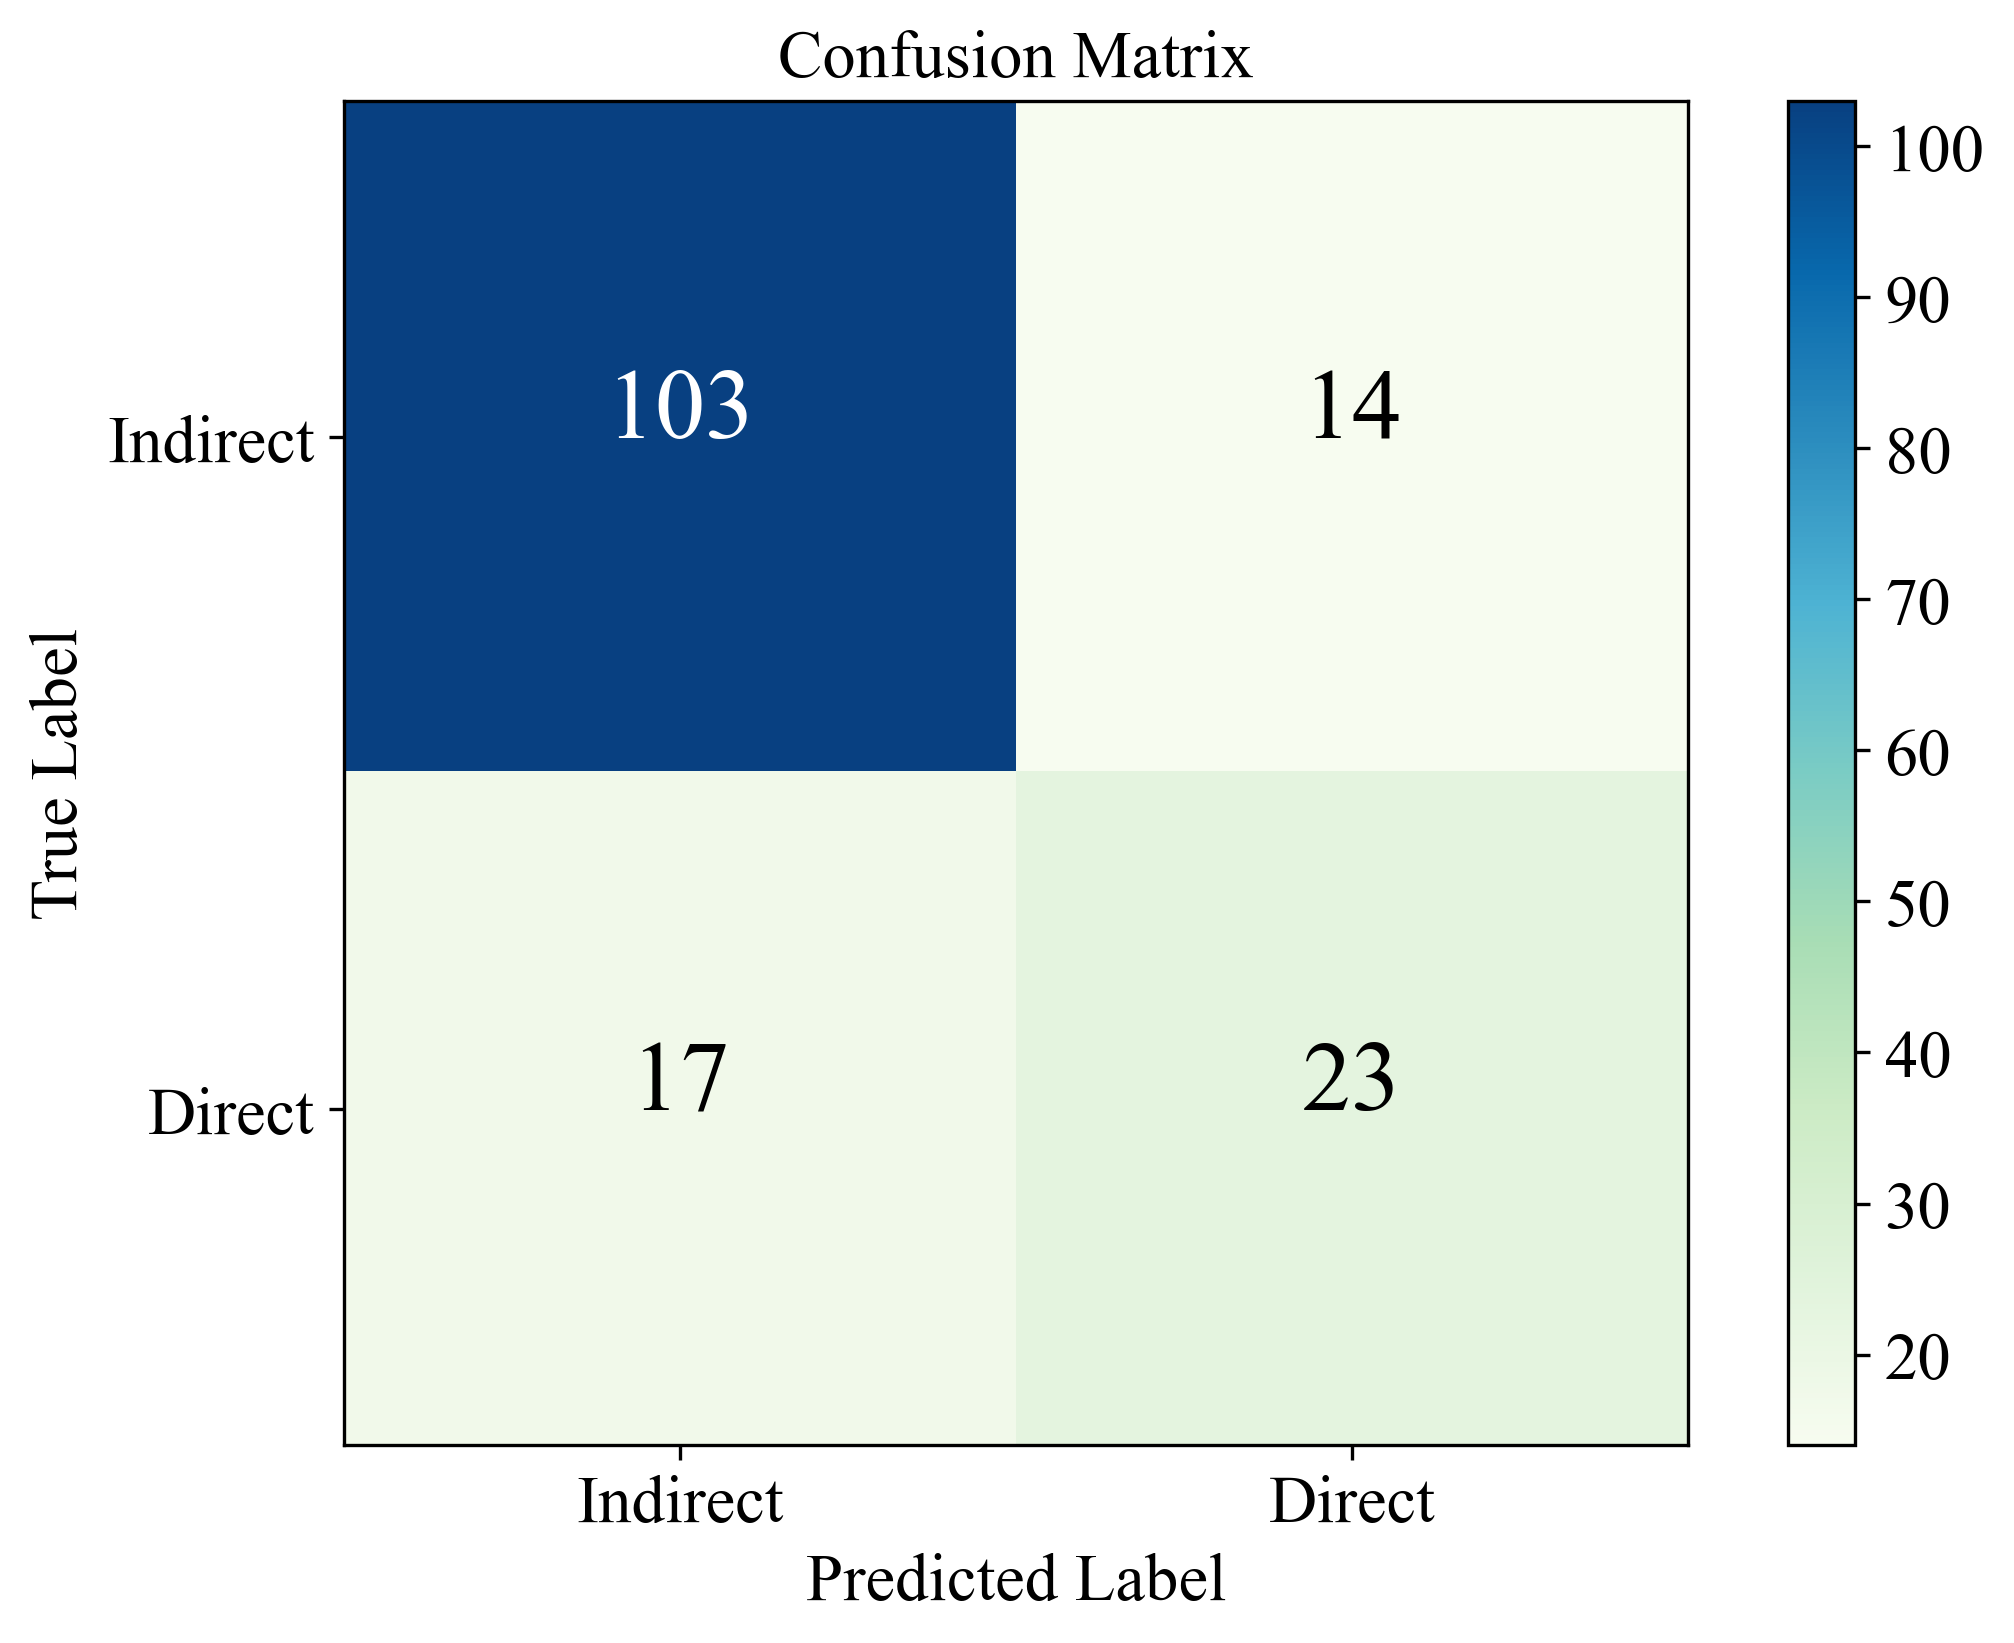

In [15]:
for y_pred in preds:
    plot_binary_confusion_matrix(y_test,y_pred)

MultipleFeaturizer:   0%|          | 0/157 [00:00<?, ?it/s]

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.82         0.345009       12         0.688728              N/A     20.27s
   1     5.05         0.432157       10         0.710395              N/A     18.58s
   2     6.71         0.441813       10         0.710395              N/A     17.49s
   3     7.82         0.473639        9         0.741404              N/A     16.27s
   4     6.58          0.50056       13         0.750889              N/A     14.82s
   5     6.50         0.515163       13         0.750889              N/A     13.43s
   6     7.65         0.487872       12         0.755704              N/A     12.16s
   7     9.11         0.530034       15          0.75658              N/A     10.91s
   8     9.18          0.55335       17         0.750962              N/A  

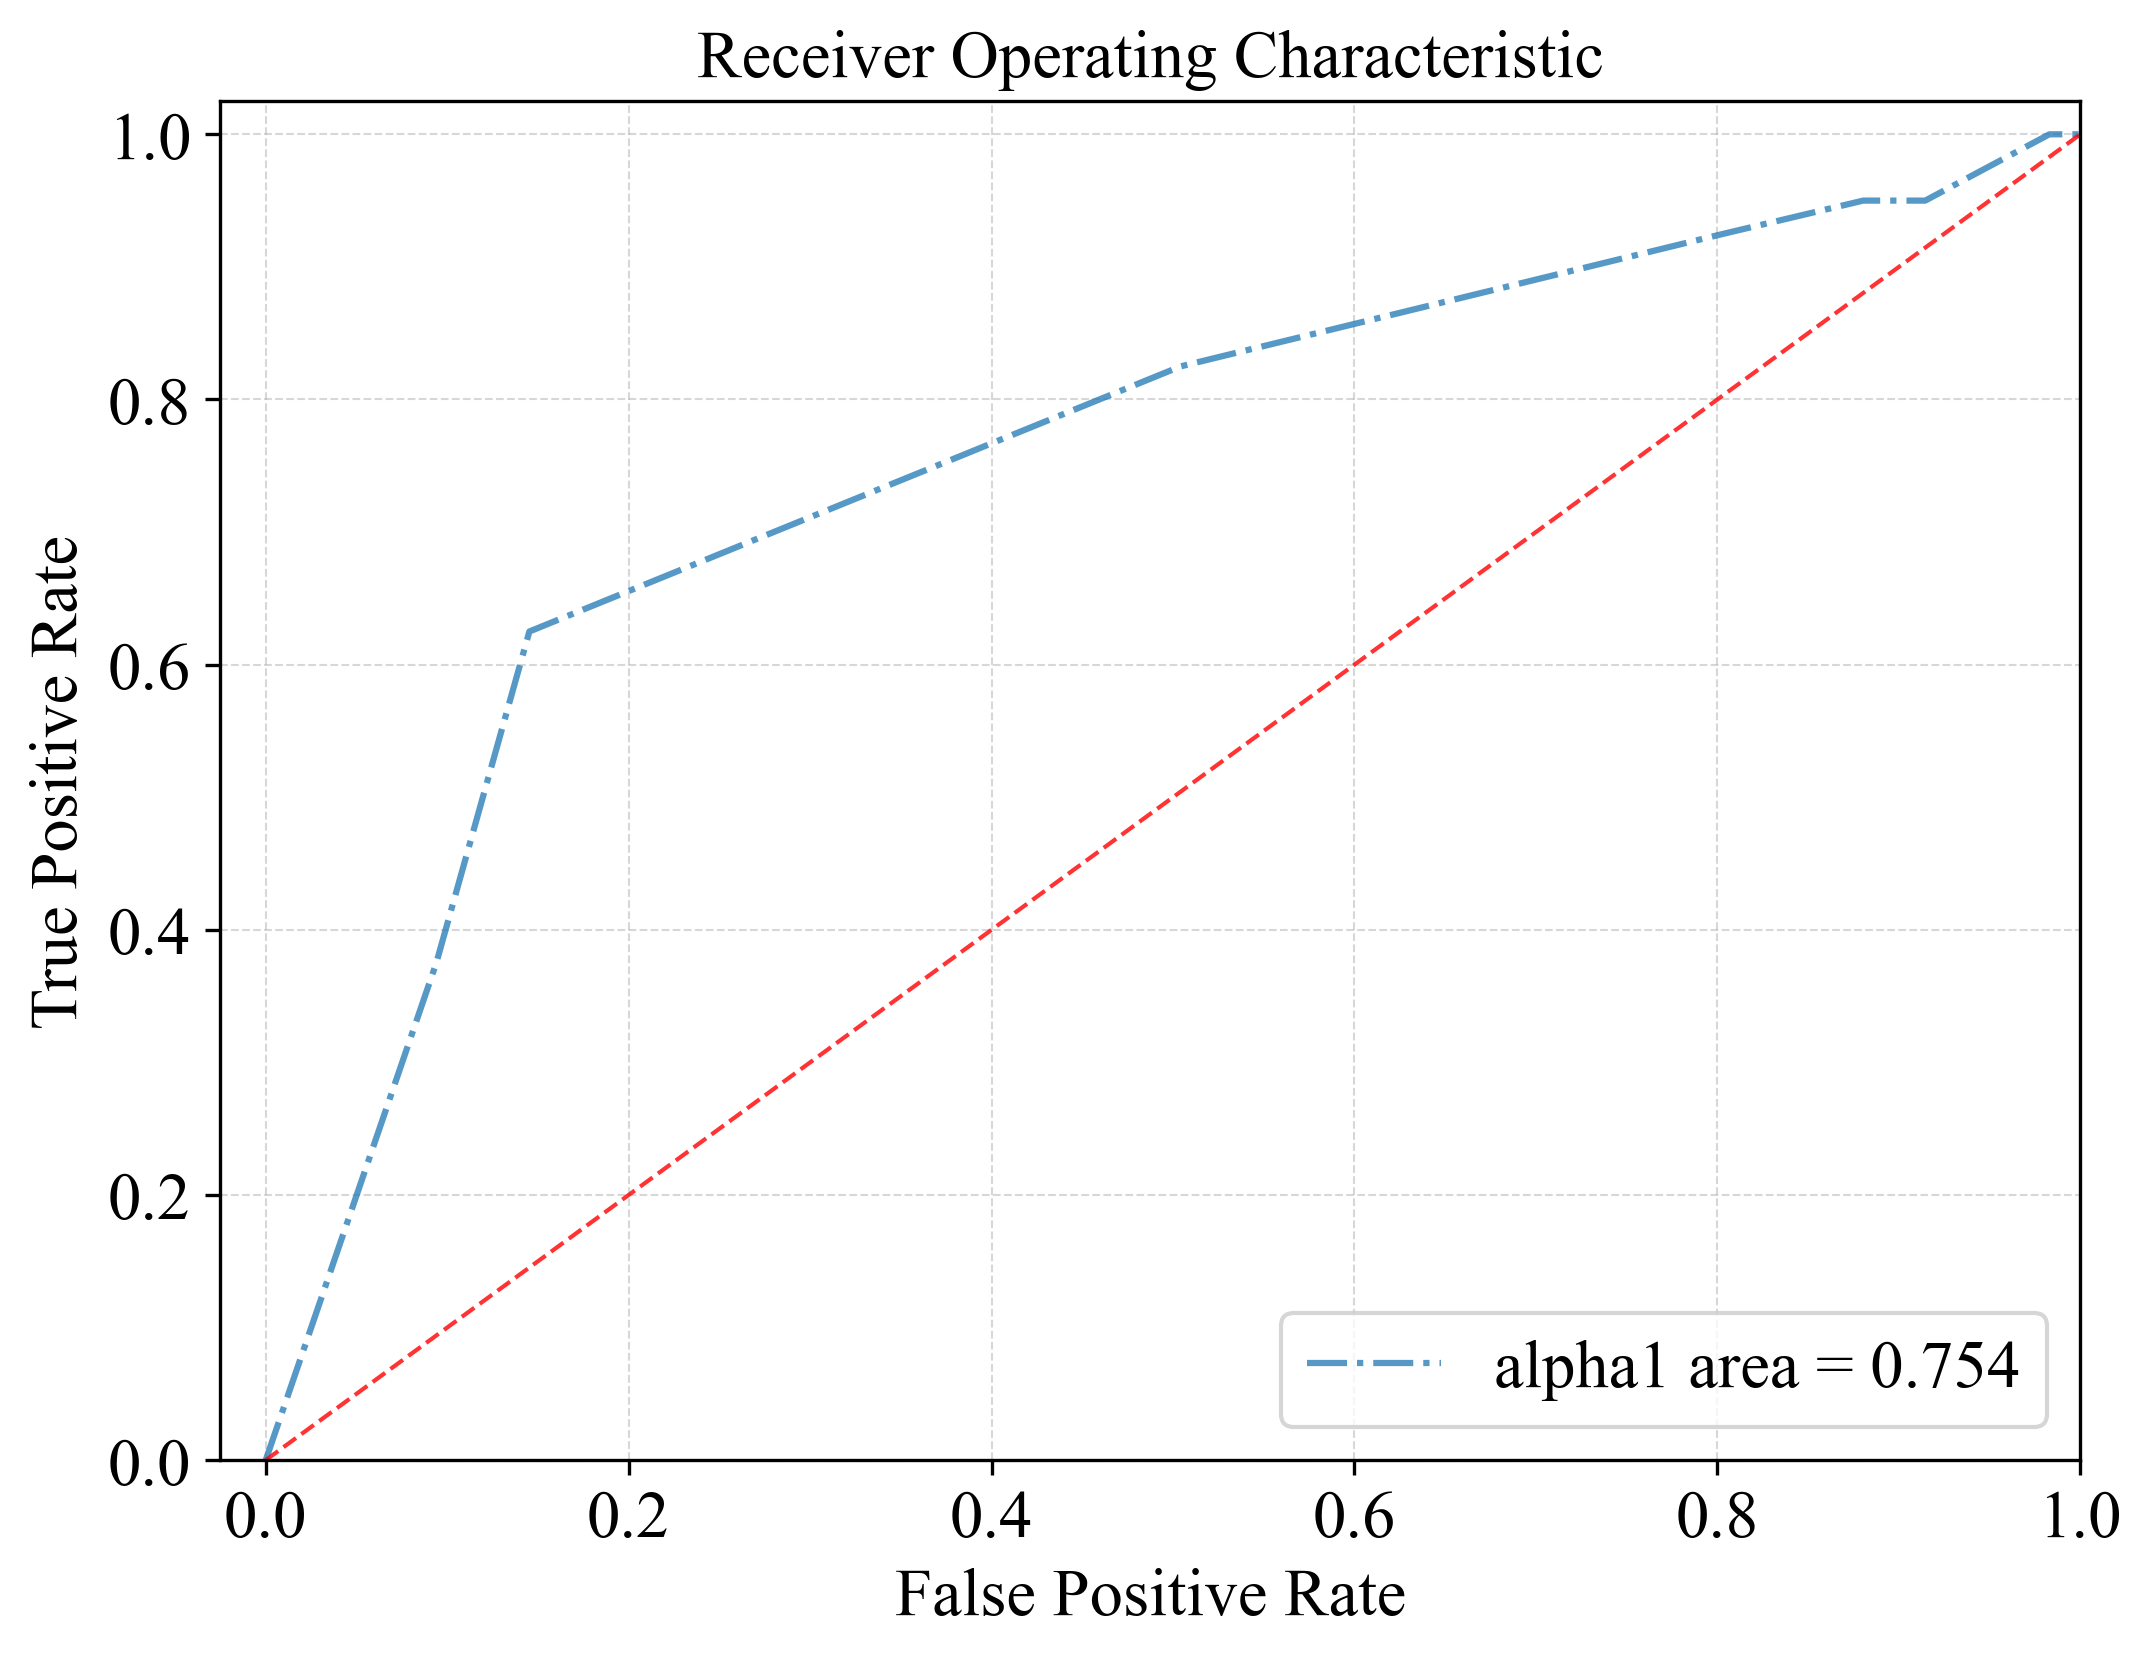

In [16]:
data_test = Featurizor(is_base=True).featurize(test,is_new_data=True,is_structure=False)
y_test = data_test[r'$y$']
X_test = data_test[X.columns]
est_gp = SymbolicTransformer(
                                population_size=1000,
                                generations=16,
                                metric=my_metric,
                                random_state=42,
                                verbose=1,
                                n_components=1,
                                parsimony_coefficient=0.005,
                                feature_names=X.columns,
                                n_jobs=1,
                                function_set=functions
                             )
est_gp.fit(X,y)
best_programs = est_gp._best_programs
best_programs_dict = {}
for p in best_programs:
    factor_name = 'alpha_' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_,'p':p}
best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict.sort_values(by='fitness')
for i,factor in  enumerate(best_programs_dict.iloc[:,-1]):
    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/factors/%s_factor_graph_pc%s' % ('test3',111000), format='png', cleanup=True)

X_test_transform = est_gp.transform(X_test)[:,-1]
y_pred = np.where(sigmoid(X_test_transform) > 0.5, 1, 0)
preds.append(y_pred)
y_prob = sigmoid(X_test_transform)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='alpha%s'%(1)+' area = %0.3f' % roc_auc, lw=1.5, linestyle='-.', alpha=0.75)
print(classification_report(y_test,y_pred))
with open('images/factors/factor_%s.txt' % 'test3', 'a') as f:
    f.write(str(best_programs_dict['p'].__str__()) + '\n')
plt.plot([0, 1], [0, 1], 'r--', lw=1, alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.025])
plt.xlim([-0.025, 1.0])
plt.title( 'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

In [17]:
best_programs_dict['p'].values[0].__str__()

'sub($Ve_b$, sub($F_b$, sub($Ns_a$, $Nd_b$)))'

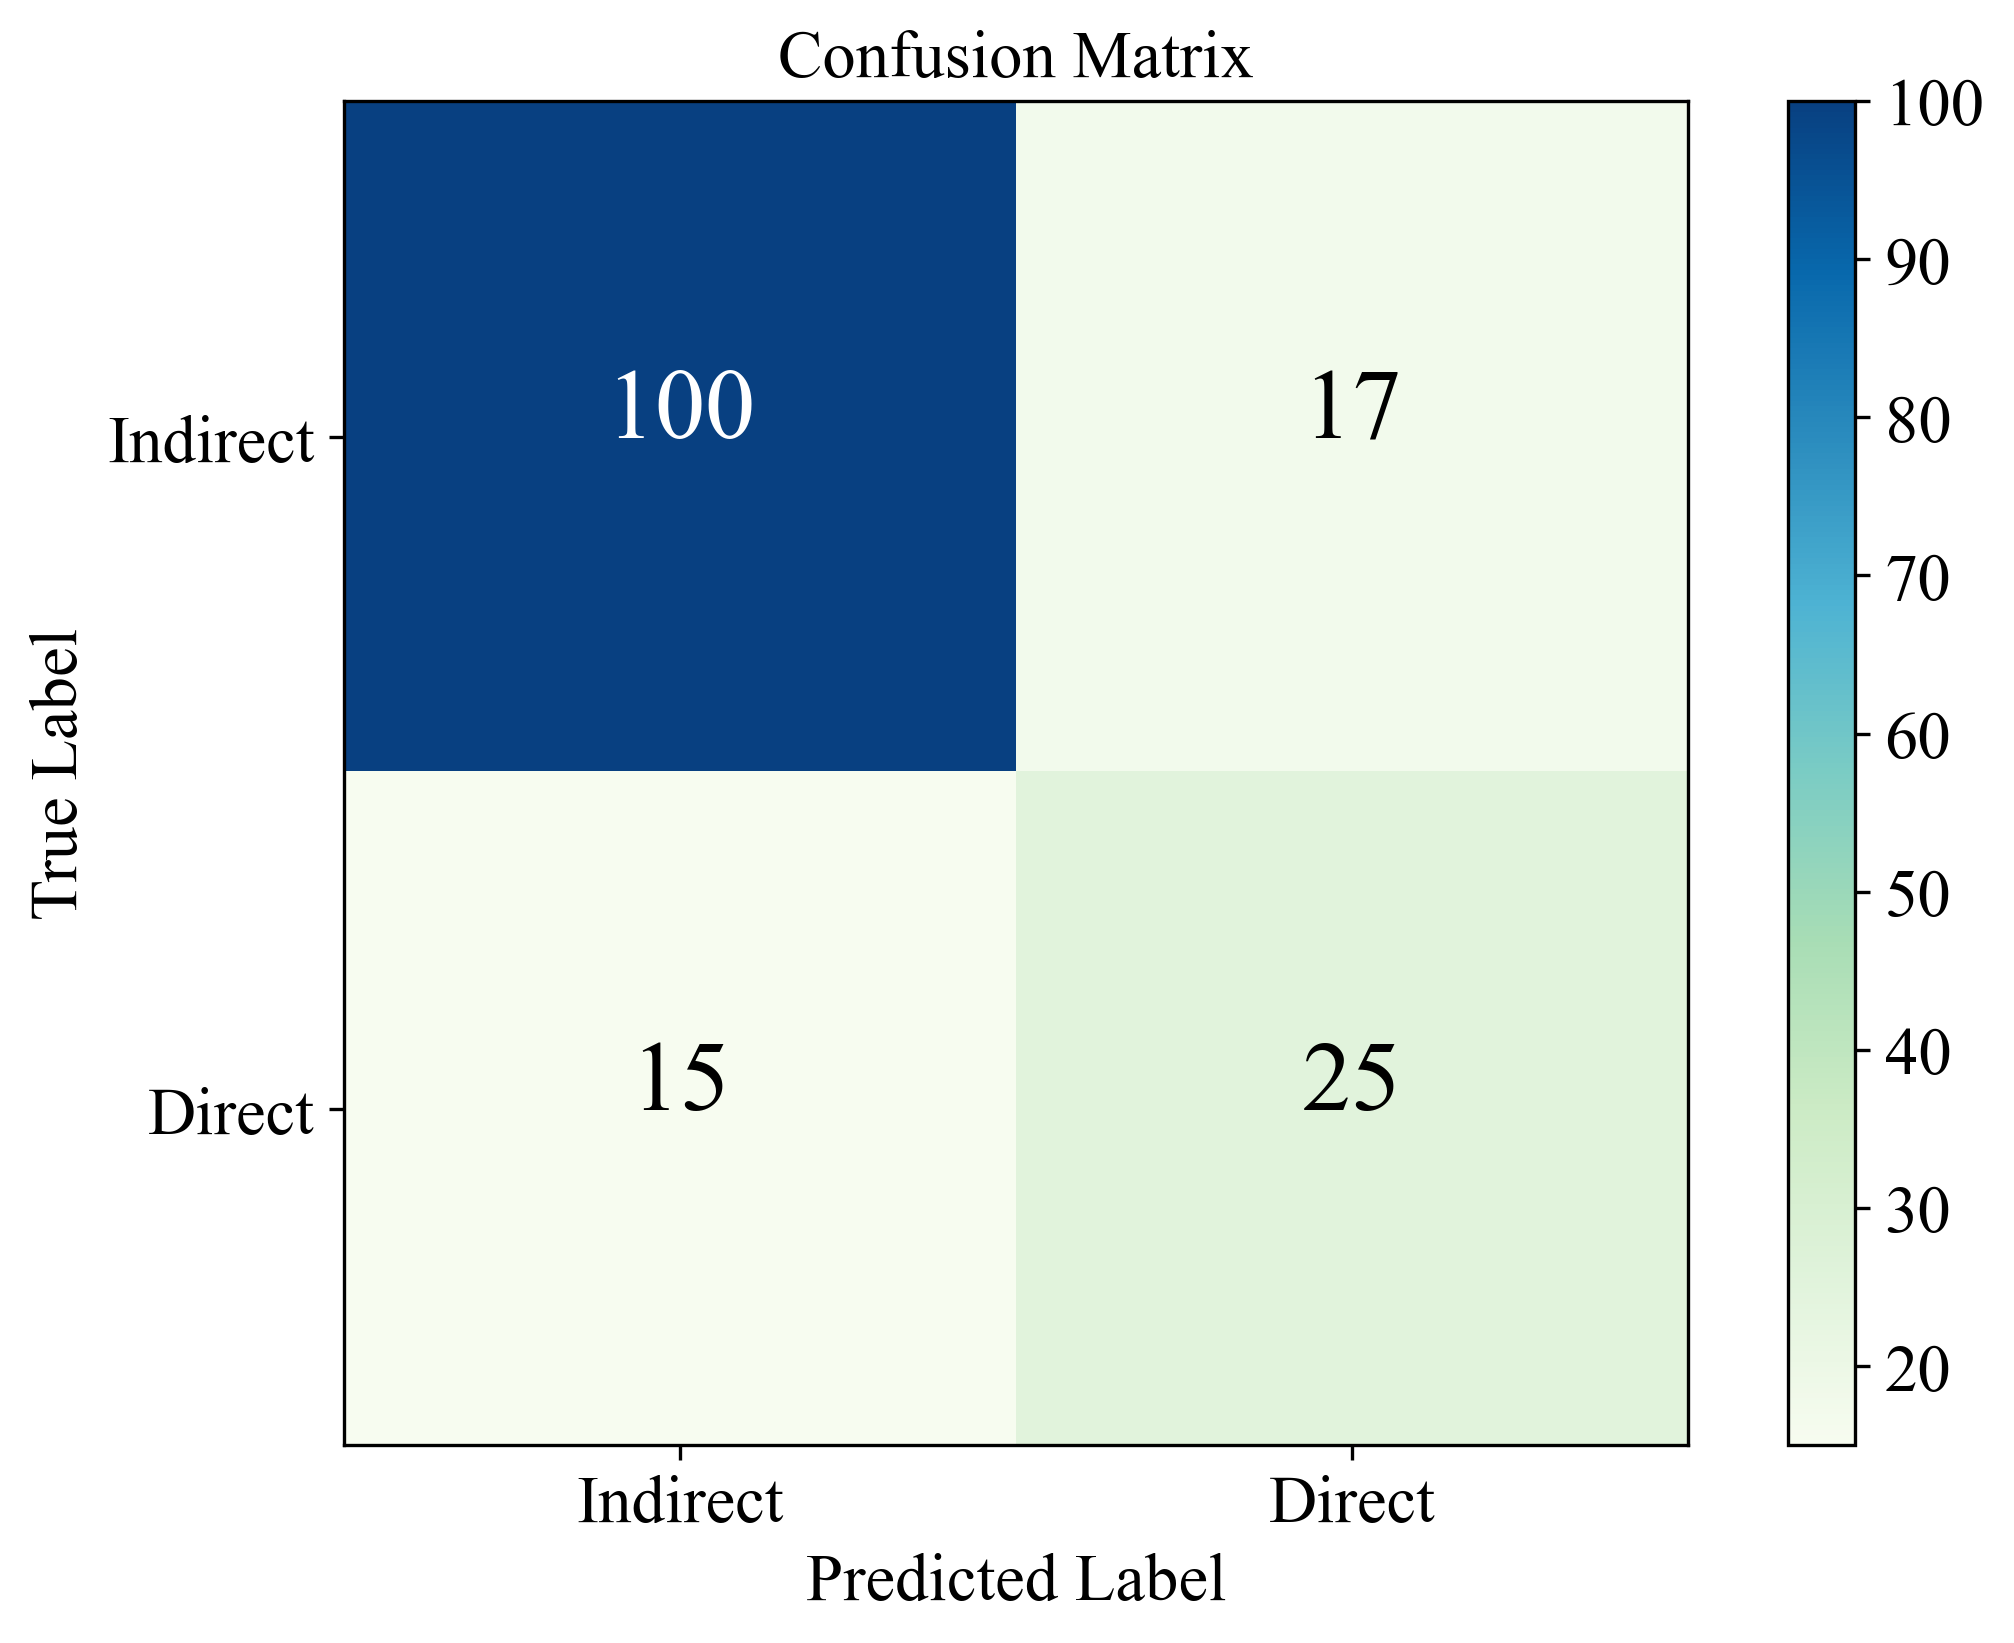

In [18]:
plot_binary_confusion_matrix(y_test,y_pred)

# Decision boundary

In [19]:
data = Featurizor(is_base=True).featurize(spinels,is_new_data=True,is_structure=False)
data_direct = data[data['$y$']==1][X.columns]
data_indirect = data[data['$y$']==0][X.columns]
def get_f(data):
    return data['$Ve_b$']-data['$F_b$']+data['$Ns_a$']-data['$Nd_b$']

MultipleFeaturizer:   0%|          | 0/315 [00:00<?, ?it/s]

In [20]:
f_direct = get_f(data_direct)
# probability_direct = sigmoid(f_direct)
f_indirect = get_f(data_indirect)
# probability_indirect = sigmoid(f_indirect)

In [21]:
from collections import Counter
f_direct = Counter(f_direct)
f_indirect = Counter(f_indirect)

In [22]:
def get_coordinate(f_dict):
    x = []
    y = []
    for k,v in f_dict.items():
        if v == 1:
            x.append(k)
            y.append(v)
            continue
        else:
            for i in range(1,v+1):
                x.append(k)
                y.append(i)
    return x,y
f_direct = get_coordinate(f_direct)
f_indirect = get_coordinate(f_indirect)

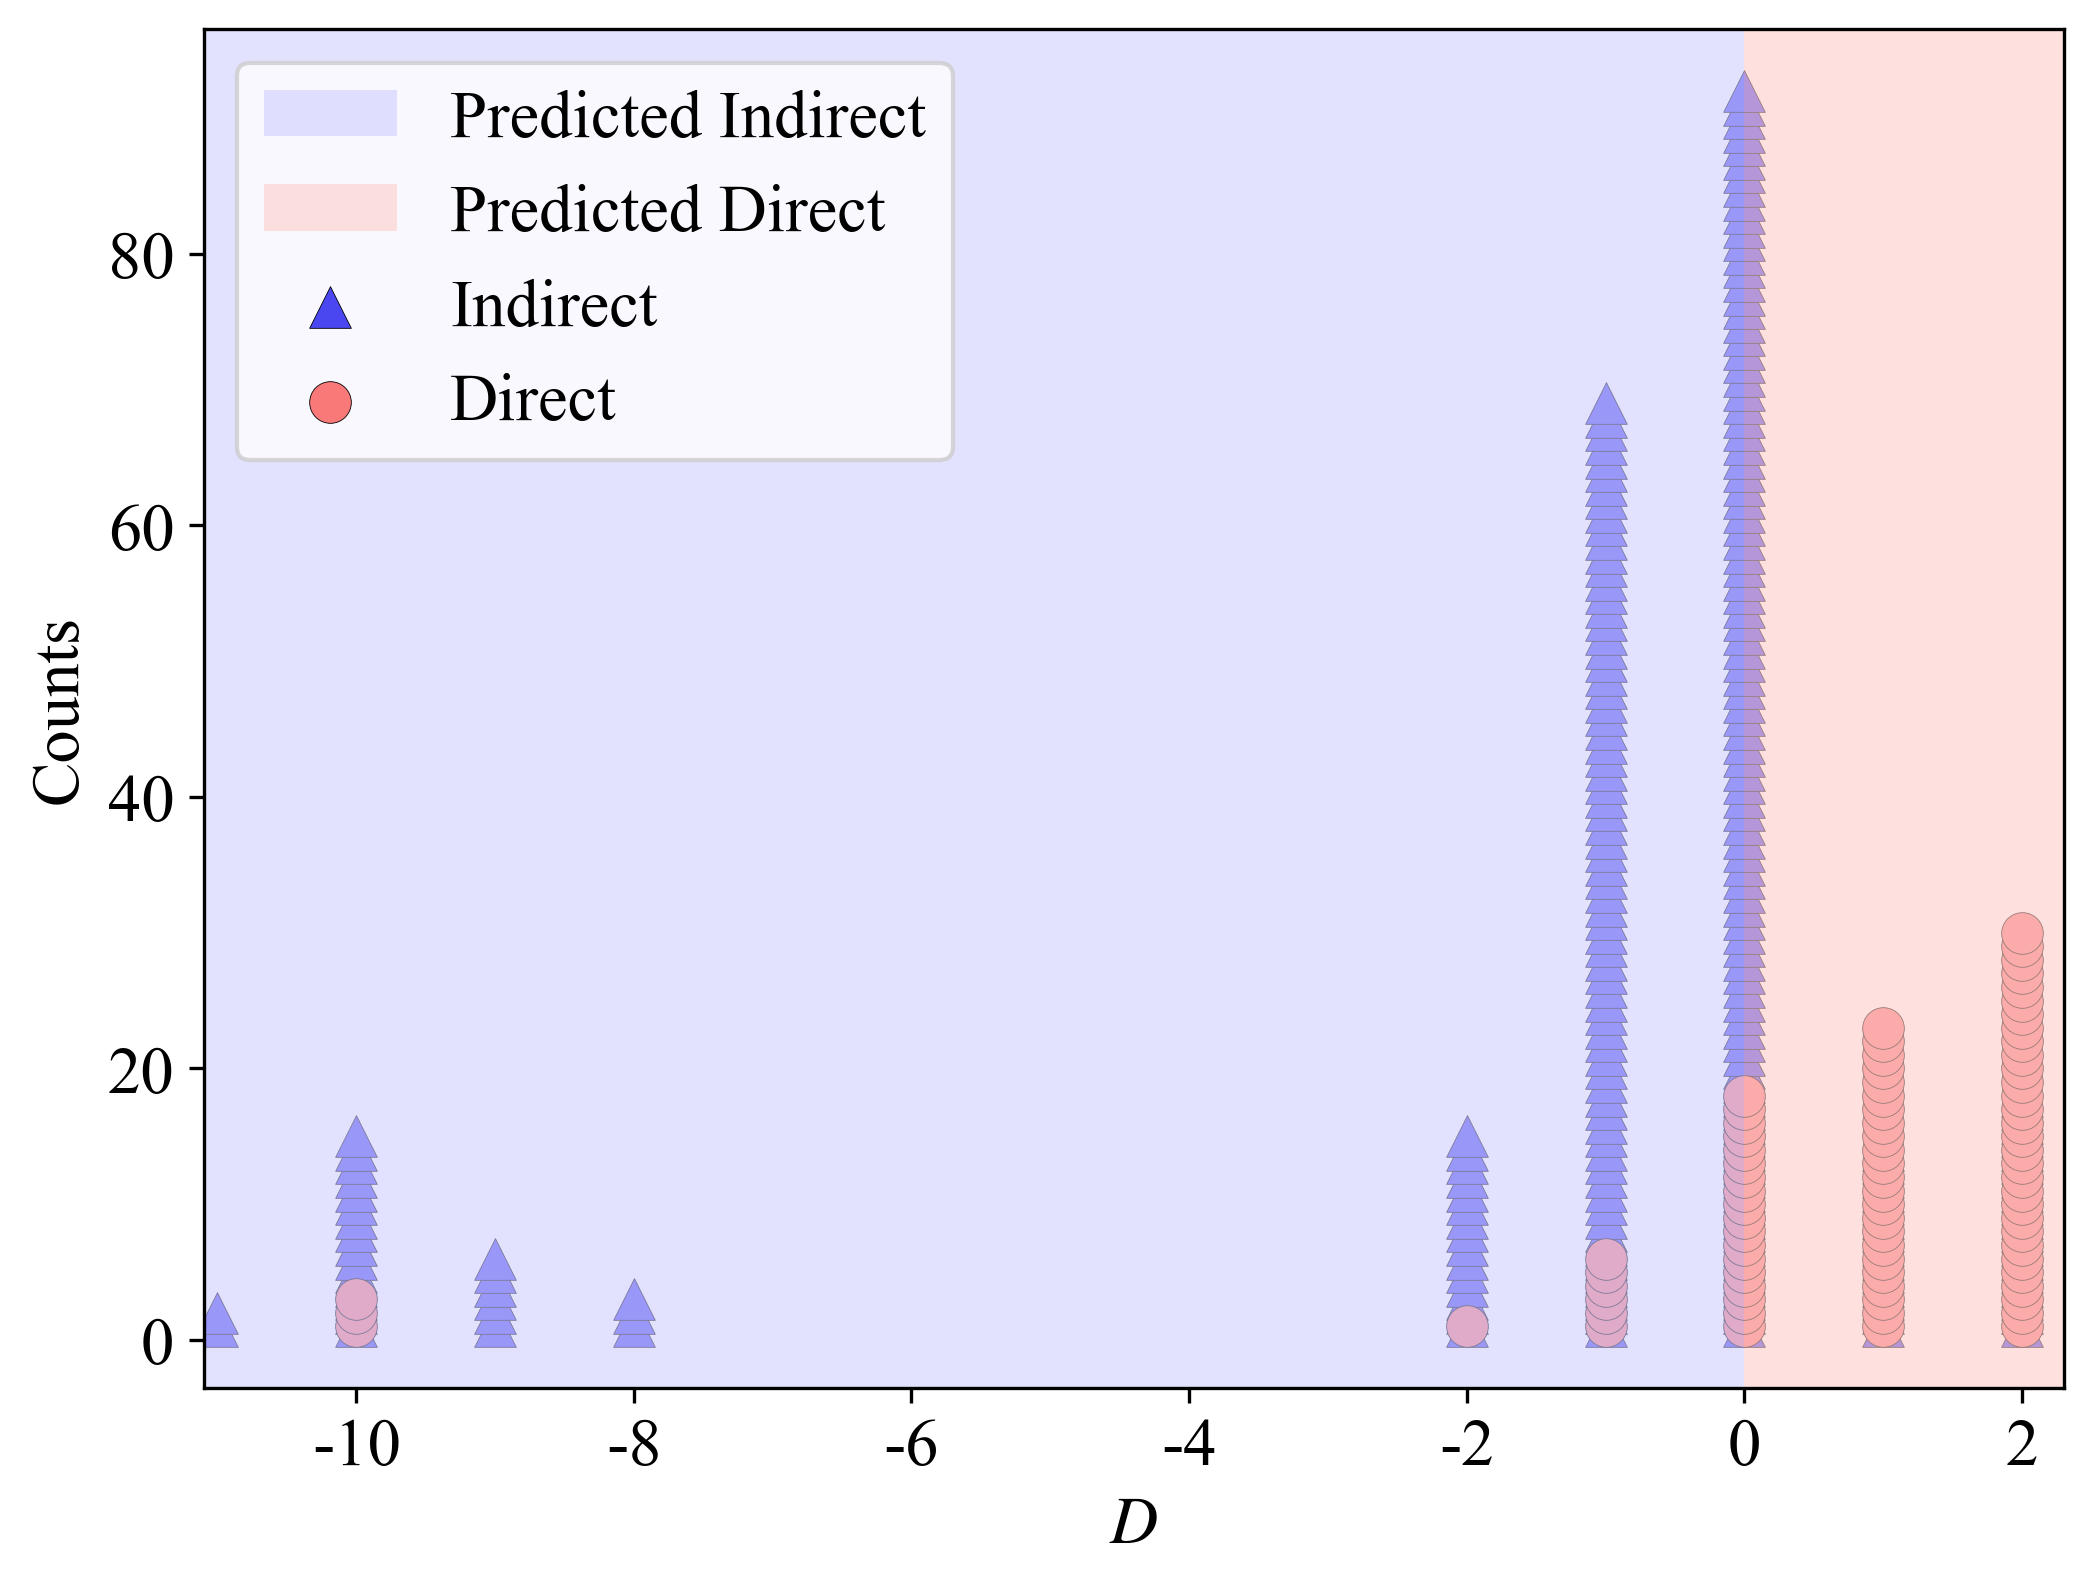

In [38]:
plt.axvspan(-11.1, 0, facecolor='#cfcdfe', label='Predicted Indirect',alpha=0.6)
plt.axvspan(0, 2.3, facecolor='#fececa',label='Predicted Direct',alpha=0.6)
plt.scatter(f_indirect[0],f_indirect[1],label='Indirect',color='#4a47f0',marker='^',edgecolors='black',s=100,lw=0.2)
plt.scatter(f_direct[0],f_direct[1],label='Direct',color='#f97979',edgecolors='black',s=100,lw=0.2)
plt.xlim(-11.1,2.3)
plt.legend()
plt.ylabel('Counts')
plt.xlabel('$D$')
plt.show()

In [24]:
data['f_prediction'] =  [1 if x >0 else 0 for x in get_f(data)]
data[['$y$','f_prediction']]

$y$  f_prediction
0      0             0
1      0             0
2      1             0
3      1             0
4      0             1
..   ...           ...
310    1             1
311    0             0
312    0             0
313    0             1
314    0             1

[315 rows x 2 columns]

In [25]:
accuracy_score(data['$y$'],data['f_prediction'])

0.8095238095238095

In [26]:

def binary_performances(y_true, y_prob, thresh=0.5, labels=['Direct','Indirect']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['TN', 'FP',
               'FN', 'TP']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)
    
    return results

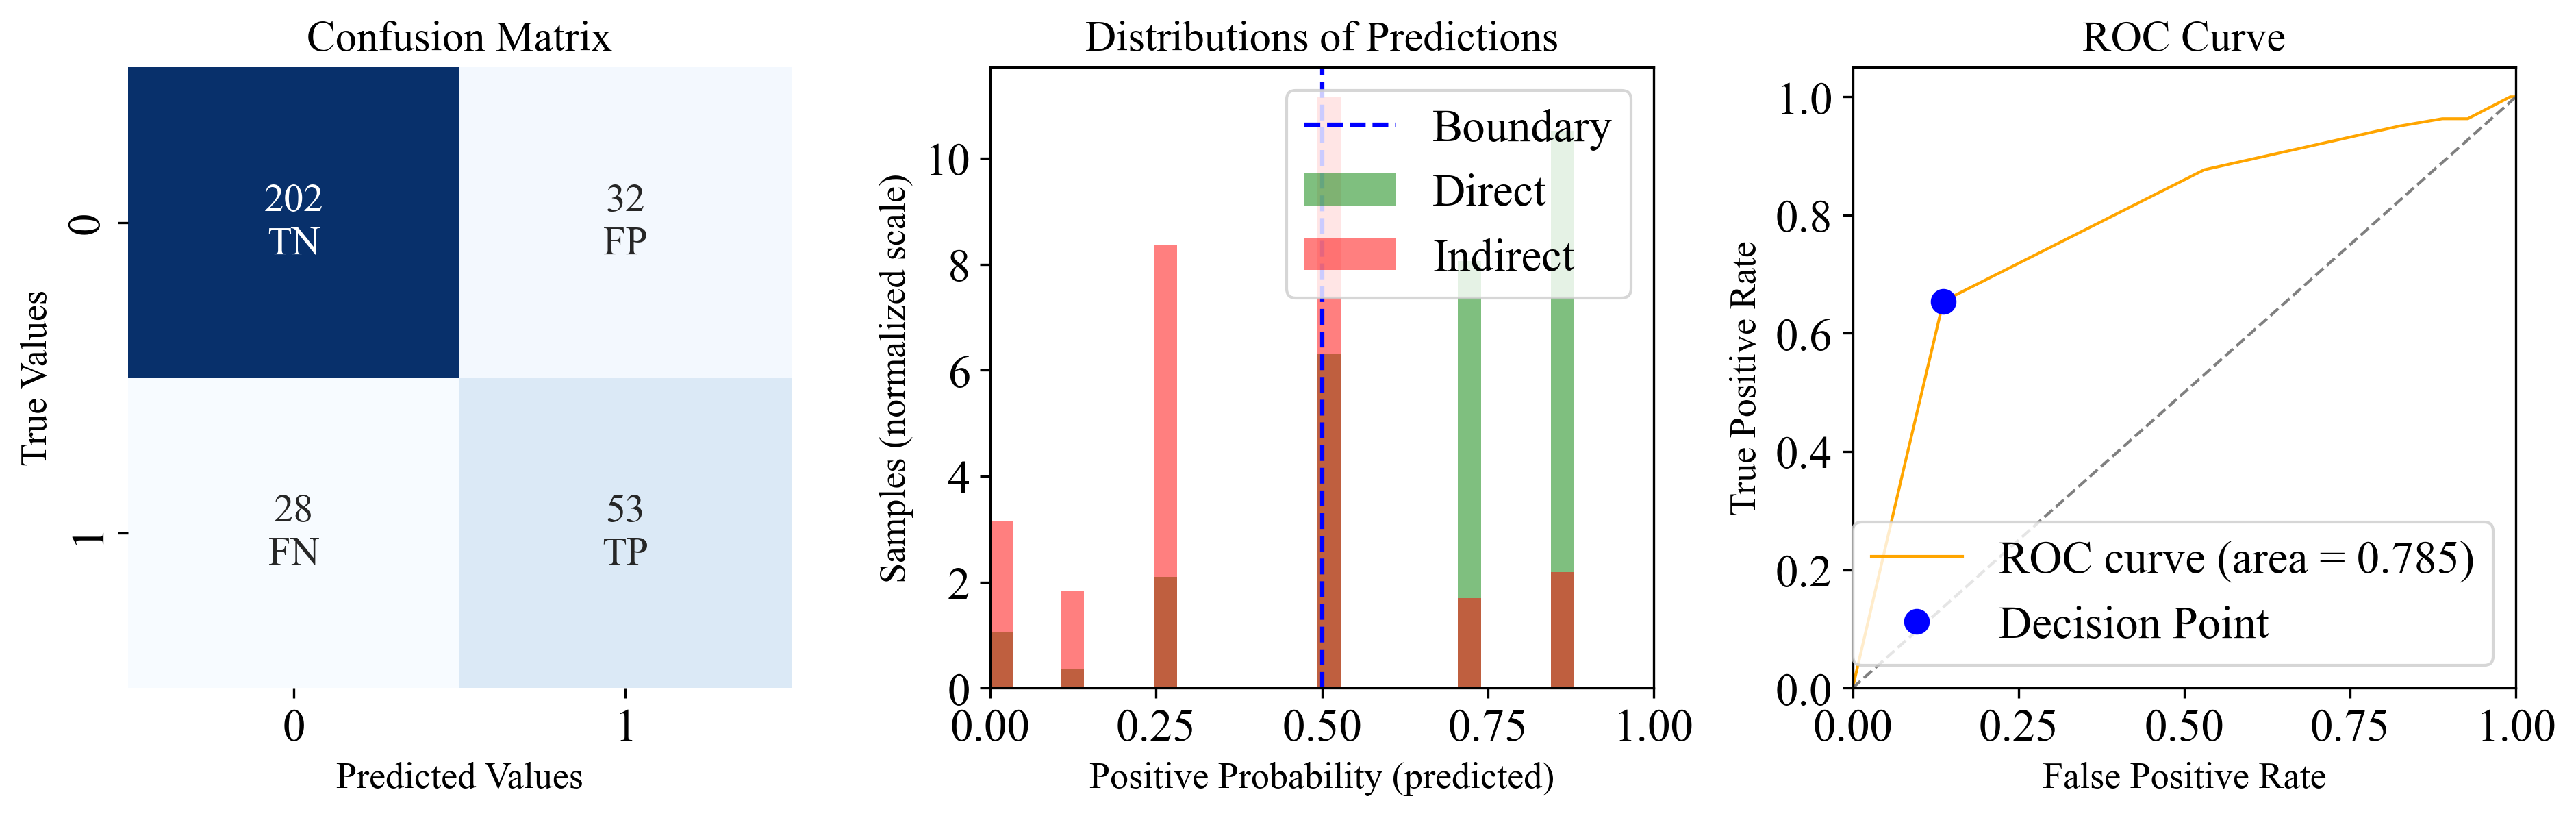

Precision: 0.624 | Recall: 0.654 | F1 Score: 0.639 | AUC: 0.785


{'Precision': 0.6235294117647059,
 'Recall': 0.654320987654321,
 'F1 Score': 0.6385542168674699,
 'AUC': 0.7850585628363407}

In [27]:
binary_performances(data['$y$'],sigmoid(get_f(data)))

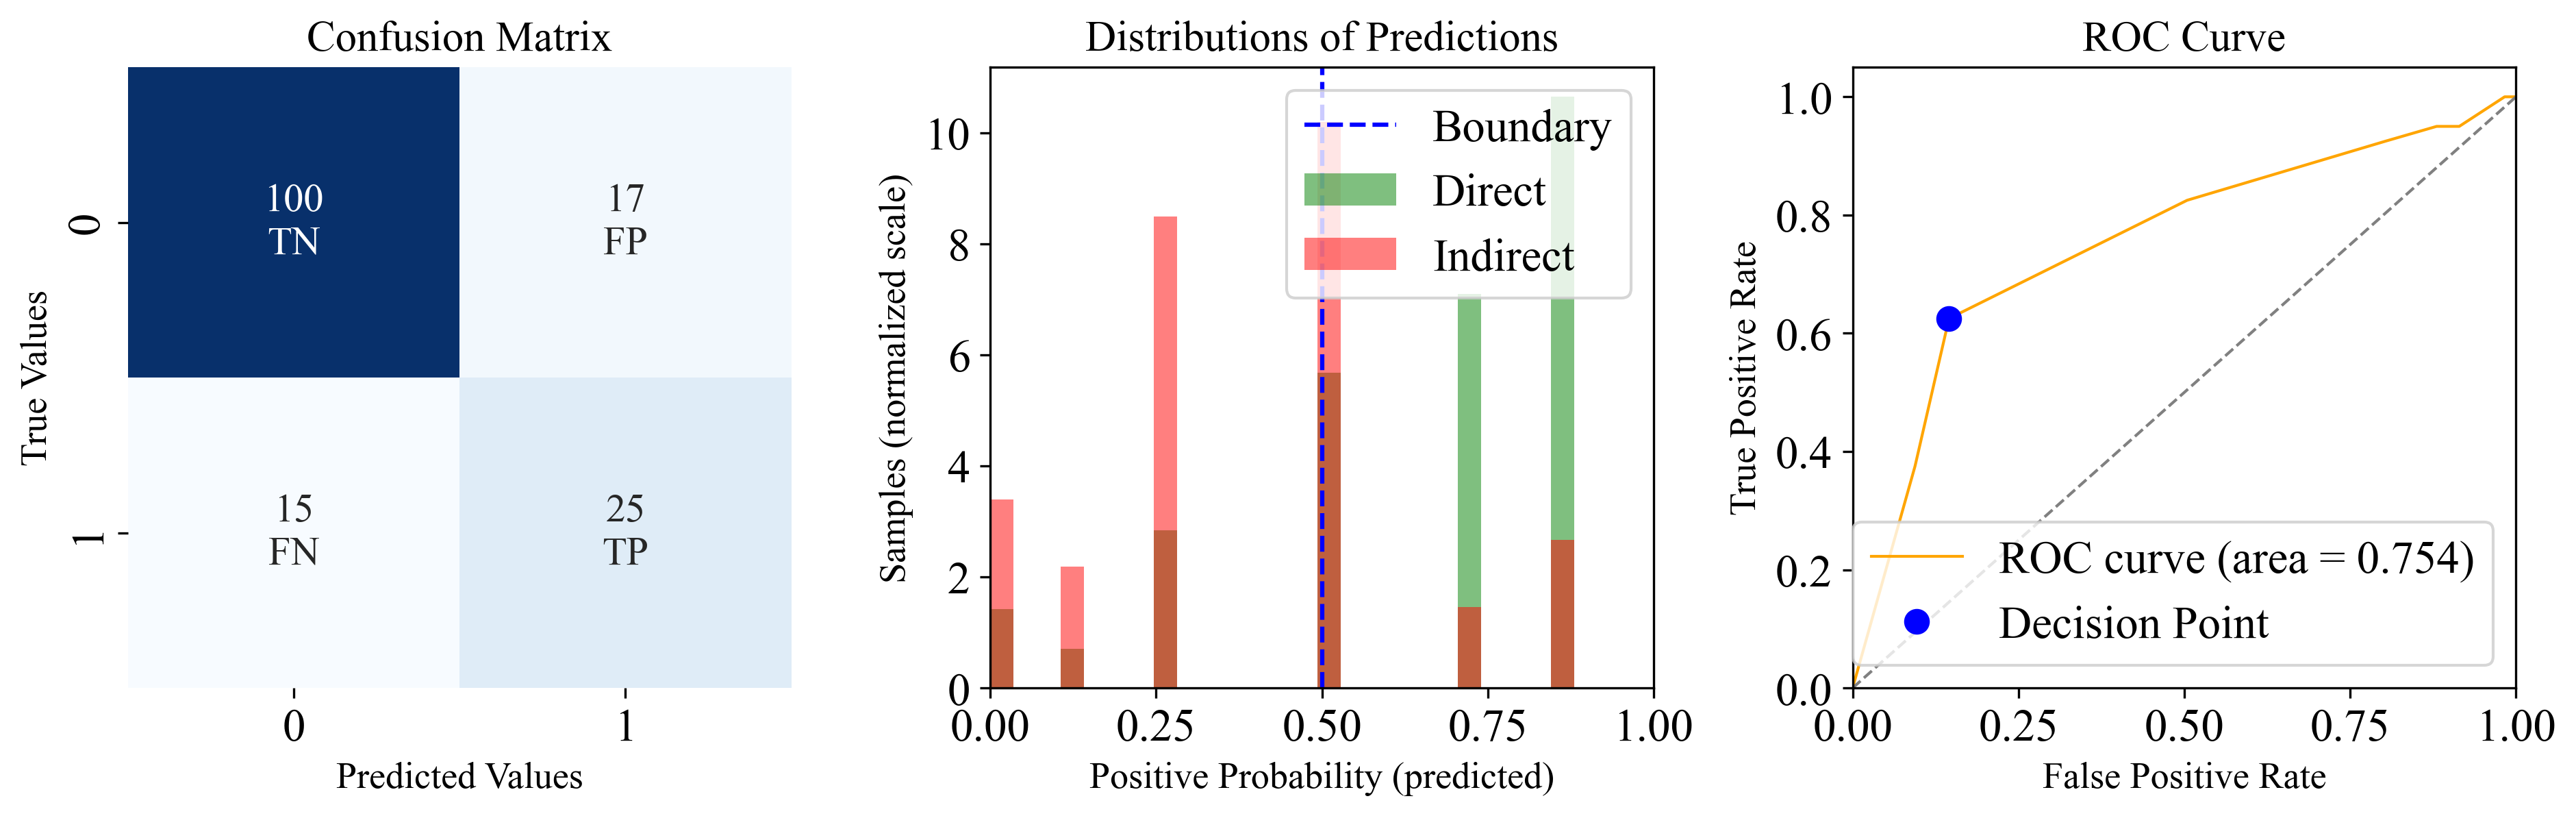

Precision: 0.595 | Recall: 0.625 | F1 Score: 0.61 | AUC: 0.754


{'Precision': 0.5952380952380952,
 'Recall': 0.625,
 'F1 Score': 0.6097560975609756,
 'AUC': 0.7536324786324785}

In [28]:
binary_performances(y_test,y_prob)